# Sex-specific cardiac disease classifiers

#### Packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import keras_tuner as kt
import xgboost as xgb
import shap
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from matplotlib import pyplot as plt

## DATA

#### Data import and pre-processing

In [2]:
csv_file = 'HeartDiseaseLarge.csv'
dataframe = pd.read_csv(csv_file)
dataframe = dataframe.sample(frac = 1, random_state = 1).reset_index(drop = True) # Shuffle the data frame for randomness

def preprocess_df(dataframe, sex = 'both') :
    # dataframe = pd.read_csv(csv_file)
    if sex == 'female' :
        dataframe = dataframe.loc[dataframe['Sex'] == 0]
    elif sex == 'male' :
        dataframe = dataframe.loc[dataframe['Sex'] == 1]
        
    dataframe = dataframe.drop(columns = ['eid']) # Drop the eid column
    
    if not sex == 'both' :
        dataframe = dataframe.drop(columns = ['Sex'])
        
    m_patients = len(dataframe.index) # Number of patients
    
    return dataframe, m_patients
    
def buildXY(dataframe) :
    df = dataframe.copy()
    target_all = df.pop('HeartDisease') # OUTPUT
    target_hyper = df.pop('HypertensiveDiseases')
    target_isch = df.pop('IschaemicHeartDiseases')
    target_cond = df.pop('ConductionDisorders')
    targets = [target_all, target_hyper, target_isch, target_cond]
    
    features_tensor = tf.convert_to_tensor(df) # INPUT features (tensor)
    
    return df, features_tensor, targets

df_both, m_both = preprocess_df(dataframe)
df_female, m_female = preprocess_df(dataframe, sex = 'female')
df_male, m_male = preprocess_df(dataframe, sex = 'male')

features_both_df, features_both, targets_both = buildXY(df_both)
features_female_df, features_female, targets_female = buildXY(df_female)
features_male_df, features_male, targets_male = buildXY(df_male)
features_df = [features_both_df, features_female_df, features_male_df]
features = [features_both, features_female, features_male]
targets = [targets_both, targets_female, targets_male]



Plot some relations of the features to the disease

AttributeError: 'PairGrid' object has no attribute 'get_figure'

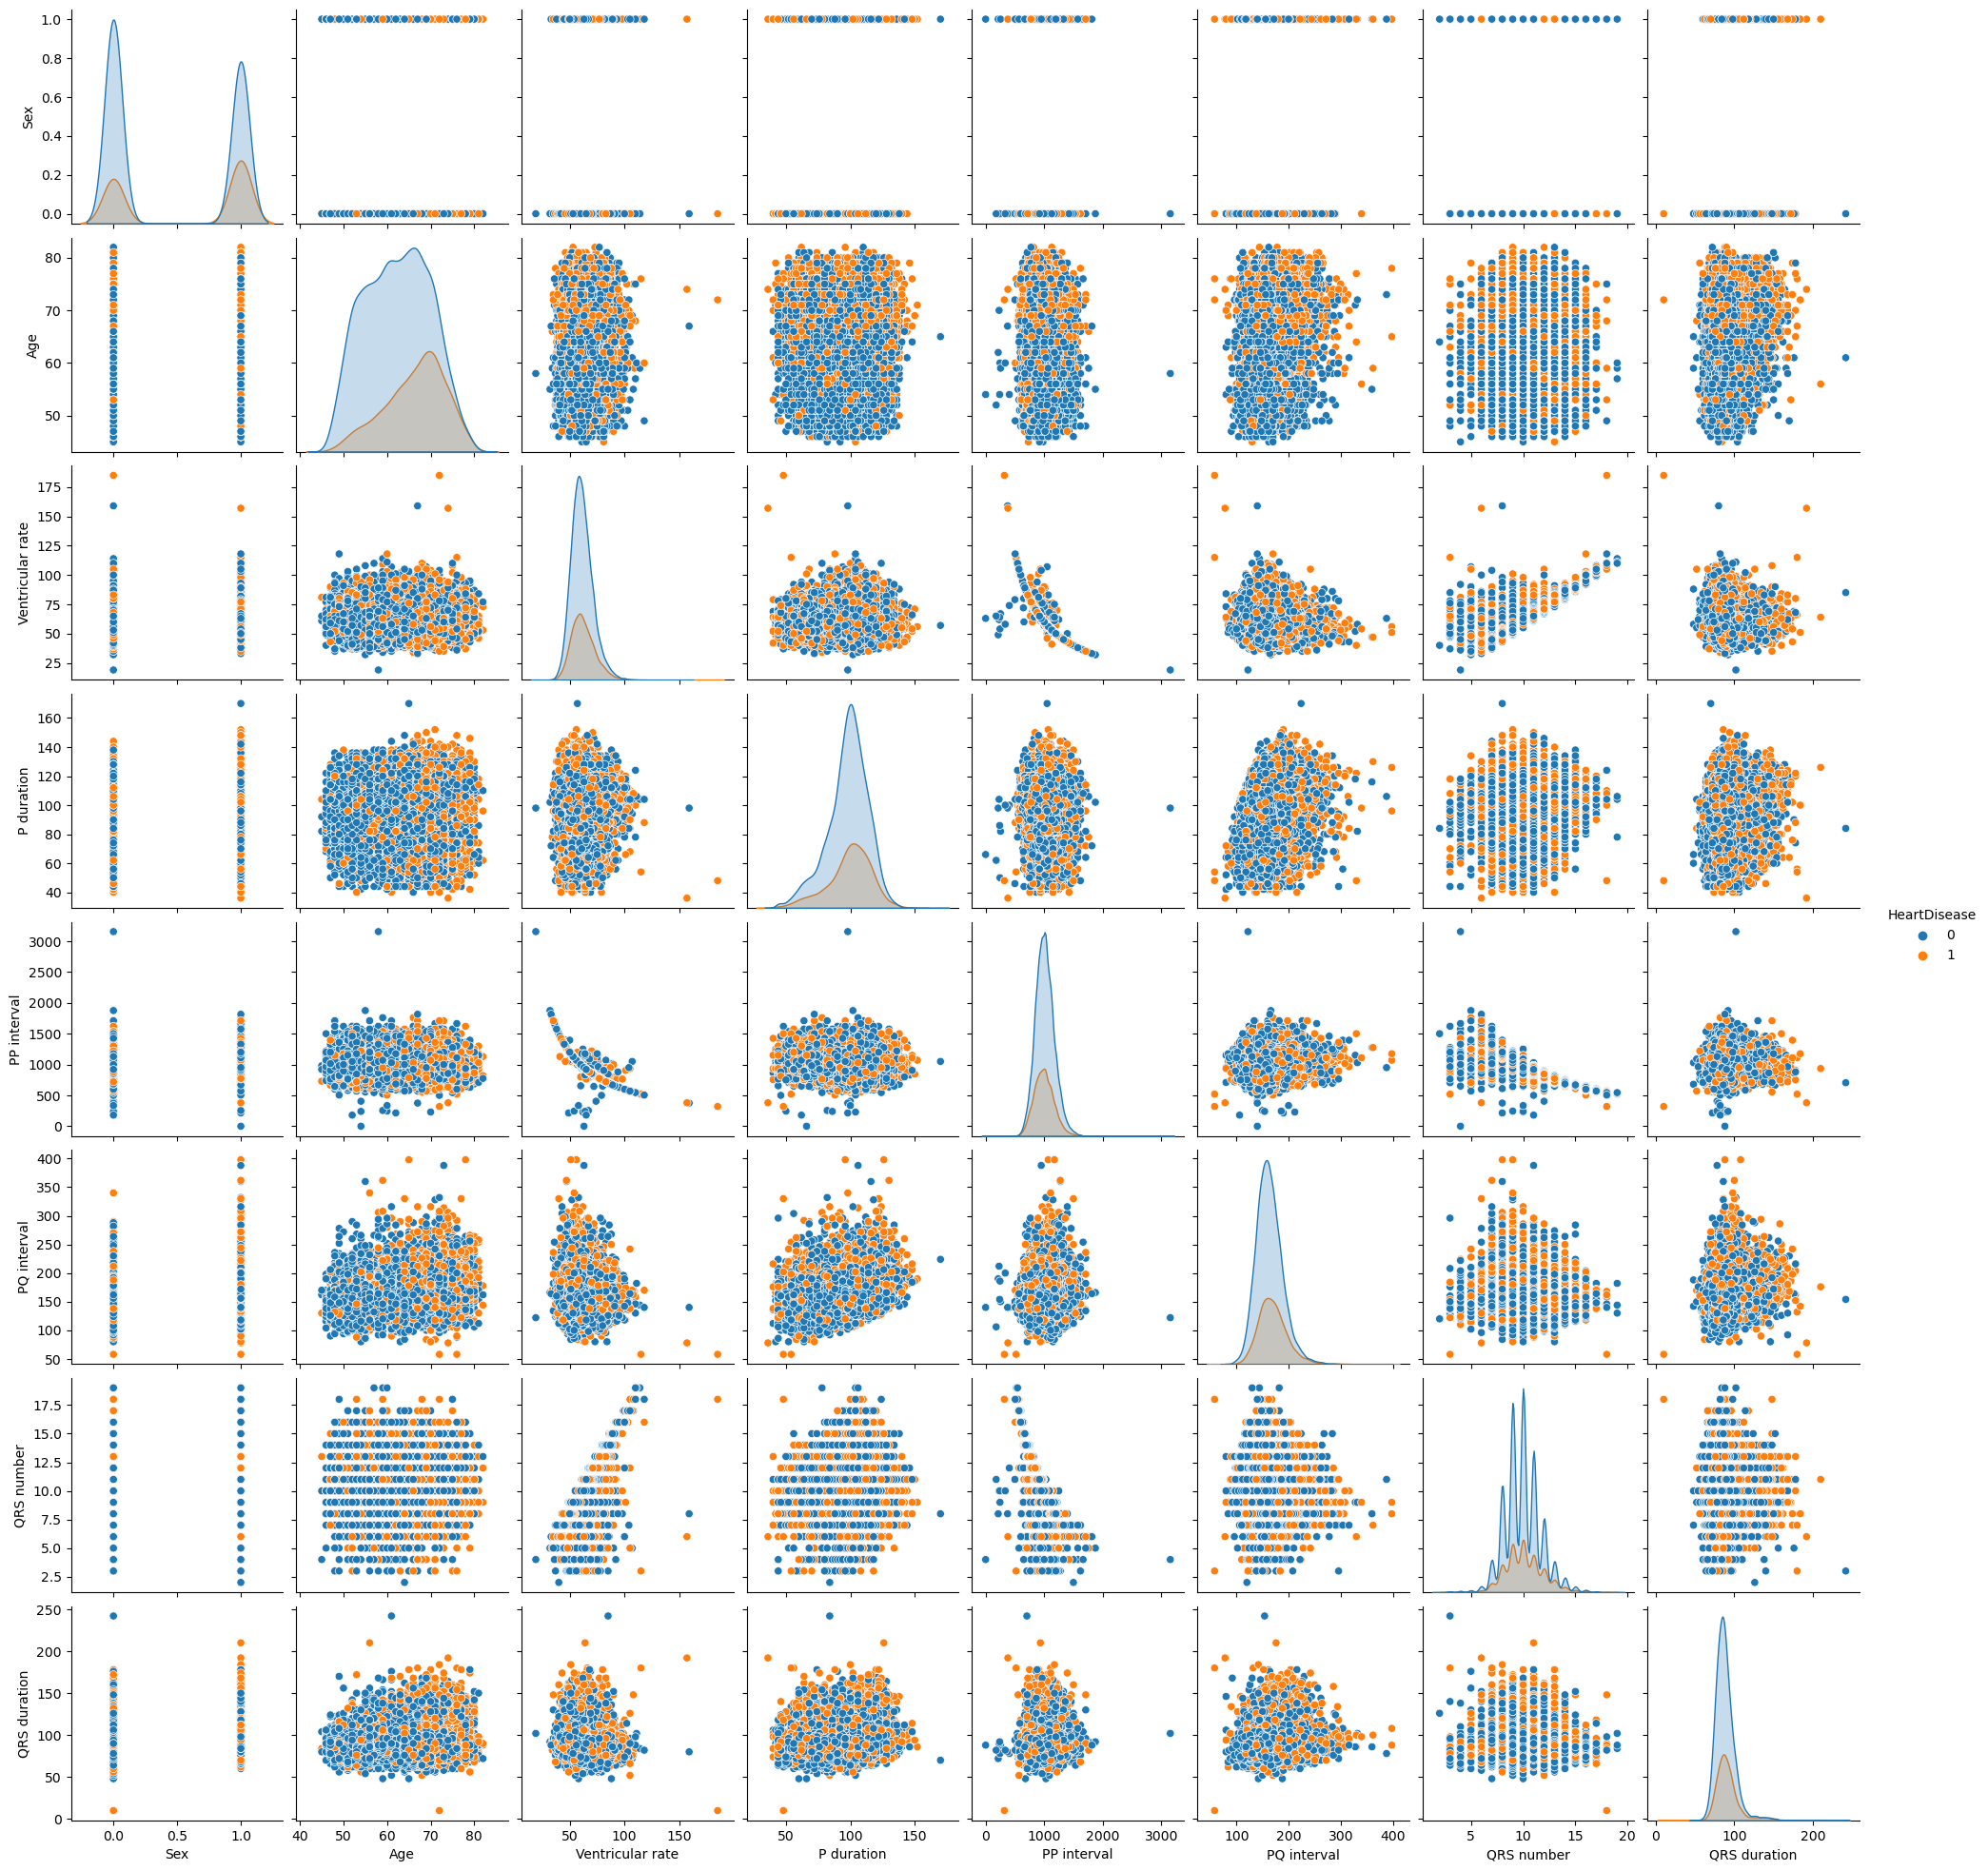

In [106]:
feature_plot = sns.pairplot(df_both.iloc[:, np.r_[-4, 0:8]], hue = 'HeartDisease', diag_kind='kde');

In [108]:
fig = feature_plot.fig
fig.savefig("PairwisePlot.png", dpi = 600) 

## MODELS

### Sequantial DNNs

In [3]:
def build_baseline_DNN(features, target, train_frac = 0.8, valtest_frac = 0.2, batch_size = 32, max_epochs = 100, oversample = False) :
    # Constants for training/val/testing and batching
    m = len(target) # number of patients
    m_validate = int(valtest_frac / 2 * m) # test size is same as validation size
    m_train = int(train_frac * m)
    buffer_size = m
    # steps_per_epoch = m_train // batch_size
    
    train_features = features[0:m_train, :]
    train_target = target[0:m_train]

    # Build dataset object from the tensor
    ds = tf.data.Dataset.from_tensor_slices((features, target))
    
    # Split into training, validation, and testing sets
    train_ds = []
    if oversample :
        # Adapted from: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
        bool_train_labels = train_target != 0
    
        #pos_features = train_features[bool_train_labels, :]
        pos_features = tf.boolean_mask(train_features, bool_train_labels)
        neg_features = tf.boolean_mask(train_features, ~bool_train_labels)
        #neg_features = train_features[~bool_train_labels, :]
        
        pos_labels = train_target[bool_train_labels]
        neg_labels = train_target[~bool_train_labels]
        
        pos_ds = tf.data.Dataset.from_tensor_slices((pos_features, pos_labels)).shuffle(buffer_size).repeat()
        neg_ds = tf.data.Dataset.from_tensor_slices((neg_features, neg_labels)).shuffle(buffer_size).repeat()
        train_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5]).batch(batch_size).prefetch(2)
        _, neg = np.bincount(target)
        steps_per_epoch = np.ceil(2.0 * neg / batch_size)
    else :
        train_ds = ds.take(m_train).cache()
        train_ds = train_ds.shuffle(buffer_size, reshuffle_each_iteration = True).repeat().batch(batch_size).prefetch(2)
        steps_per_epoch = m_train // batch_size
    
        
    validate_ds = ds.skip(m_train).take(m_validate).cache()
    test_ds = ds.skip(m_train).skip(m_validate).cache()

    # Shuffle and batch the training and validation sets (no shuffling for validation set)
    validate_ds = validate_ds.batch(batch_size).prefetch(2)
    
    # Standarization layer
    # normalizer = normalization_layer(train_ds)
    normalizer = tf.keras.layers.Normalization(axis = -1)
    normalizer.adapt(train_features)
    
    # Sequential DNN for binary classification
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(30, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer = 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])
    
    return (model, train_ds, validate_ds, test_ds, steps_per_epoch, max_epochs)

#### Build 12 DNN models

In [4]:
TEST_SIZE_MLP = 0.1

In [5]:
MAX_EPOCHS = 100
models_dnn = [build_baseline_DNN(features[i], Y, valtest_frac = TEST_SIZE_MLP * 2, max_epochs = MAX_EPOCHS, oversample = True) for i in range(len(features)) for Y in targets[i]]

#### Train the 12 DNN models

In [6]:
# SERIAL
history = [dnn[0].fit(dnn[1], steps_per_epoch = dnn[4], epochs = dnn[5], validation_data = dnn[2], verbose = 1) for dnn in models_dnn]

Epoch 1/100
400/400 [==============================] - 2s 2ms/step - loss: 2.2248 - accuracy: 0.6041 - precision: 0.6064 - recall: 0.6055 - val_loss: 1.8221 - val_accuracy: 0.6950 - val_precision: 0.4151 - val_recall: 0.4591
Epoch 2/100
400/400 [==============================] - 1s 2ms/step - loss: 1.6149 - accuracy: 0.6257 - precision: 0.6227 - recall: 0.6366 - val_loss: 1.3655 - val_accuracy: 0.6418 - val_precision: 0.3703 - val_recall: 0.5634
Epoch 3/100
400/400 [==============================] - 1s 2ms/step - loss: 1.2306 - accuracy: 0.6355 - precision: 0.6231 - recall: 0.6749 - val_loss: 1.0526 - val_accuracy: 0.6558 - val_precision: 0.3848 - val_recall: 0.5682
Epoch 4/100
400/400 [==============================] - 1s 2ms/step - loss: 0.9849 - accuracy: 0.6459 - precision: 0.6379 - recall: 0.6686 - val_loss: 0.8771 - val_accuracy: 0.6369 - val_precision: 0.3794 - val_recall: 0.6517
Epoch 5/100
400/400 [==============================] - 1s 2ms/step - loss: 0.8403 - accuracy: 0.6421

400/400 [==============================] - 1s 2ms/step - loss: 0.6400 - accuracy: 0.6531 - precision: 0.6475 - recall: 0.6510 - val_loss: 0.6291 - val_accuracy: 0.6781 - val_precision: 0.4053 - val_recall: 0.5425
Epoch 38/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6356 - accuracy: 0.6565 - precision: 0.6477 - recall: 0.6957 - val_loss: 0.6545 - val_accuracy: 0.6088 - val_precision: 0.3685 - val_recall: 0.7335
Epoch 39/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6326 - accuracy: 0.6542 - precision: 0.6312 - recall: 0.6945 - val_loss: 0.6070 - val_accuracy: 0.6538 - val_precision: 0.3883 - val_recall: 0.6051
Epoch 40/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6351 - accuracy: 0.6555 - precision: 0.6527 - recall: 0.6895 - val_loss: 0.6755 - val_accuracy: 0.6323 - val_precision: 0.3737 - val_recall: 0.6388
Epoch 41/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6297 - accuracy: 0.6566 - preci

400/400 [==============================] - 1s 2ms/step - loss: 0.6270 - accuracy: 0.6605 - precision: 0.6400 - recall: 0.7312 - val_loss: 0.6350 - val_accuracy: 0.6533 - val_precision: 0.3921 - val_recall: 0.6356
Epoch 74/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6287 - accuracy: 0.6629 - precision: 0.6495 - recall: 0.6972 - val_loss: 0.6739 - val_accuracy: 0.5878 - val_precision: 0.3553 - val_recall: 0.7432
Epoch 75/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6316 - accuracy: 0.6541 - precision: 0.6393 - recall: 0.6872 - val_loss: 0.5896 - val_accuracy: 0.6669 - val_precision: 0.3960 - val_recall: 0.5650
Epoch 76/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6318 - accuracy: 0.6563 - precision: 0.6491 - recall: 0.7022 - val_loss: 0.6427 - val_accuracy: 0.6237 - val_precision: 0.3735 - val_recall: 0.6870
Epoch 77/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6288 - accuracy: 0.6573 - preci

296/296 [==============================] - 1s 2ms/step - loss: 0.6824 - accuracy: 0.6720 - precision: 0.6545 - recall: 0.7524 - val_loss: 0.6939 - val_accuracy: 0.6059 - val_precision: 0.2937 - val_recall: 0.7903
Epoch 10/100
296/296 [==============================] - 1s 2ms/step - loss: 0.6622 - accuracy: 0.6709 - precision: 0.6479 - recall: 0.7571 - val_loss: 0.6480 - val_accuracy: 0.6484 - val_precision: 0.3016 - val_recall: 0.6711
Epoch 11/100
296/296 [==============================] - 1s 2ms/step - loss: 0.6478 - accuracy: 0.6698 - precision: 0.6463 - recall: 0.7495 - val_loss: 0.6492 - val_accuracy: 0.6088 - val_precision: 0.2884 - val_recall: 0.7461
Epoch 12/100
296/296 [==============================] - 1s 2ms/step - loss: 0.6335 - accuracy: 0.6731 - precision: 0.6518 - recall: 0.7481 - val_loss: 0.6453 - val_accuracy: 0.6167 - val_precision: 0.2931 - val_recall: 0.7461
Epoch 13/100
296/296 [==============================] - 1s 2ms/step - loss: 0.6303 - accuracy: 0.6679 - preci

296/296 [==============================] - 1s 2ms/step - loss: 0.6119 - accuracy: 0.6865 - precision: 0.6664 - recall: 0.7760 - val_loss: 0.7076 - val_accuracy: 0.5808 - val_precision: 0.2814 - val_recall: 0.8013
Epoch 46/100
296/296 [==============================] - 1s 2ms/step - loss: 0.6133 - accuracy: 0.6788 - precision: 0.6543 - recall: 0.7725 - val_loss: 0.5572 - val_accuracy: 0.6529 - val_precision: 0.3065 - val_recall: 0.6799
Epoch 47/100
296/296 [==============================] - 1s 2ms/step - loss: 0.6104 - accuracy: 0.6831 - precision: 0.6636 - recall: 0.7795 - val_loss: 0.6606 - val_accuracy: 0.6063 - val_precision: 0.2873 - val_recall: 0.7483
Epoch 48/100
296/296 [==============================] - 1s 2ms/step - loss: 0.6144 - accuracy: 0.6786 - precision: 0.6488 - recall: 0.7751 - val_loss: 0.6119 - val_accuracy: 0.6323 - val_precision: 0.2992 - val_recall: 0.7219
Epoch 49/100
296/296 [==============================] - 1s 2ms/step - loss: 0.6104 - accuracy: 0.6759 - preci

296/296 [==============================] - 1s 2ms/step - loss: 0.6104 - accuracy: 0.6742 - precision: 0.6453 - recall: 0.7731 - val_loss: 0.5858 - val_accuracy: 0.6467 - val_precision: 0.3046 - val_recall: 0.6954
Epoch 82/100
296/296 [==============================] - 1s 2ms/step - loss: 0.6028 - accuracy: 0.6863 - precision: 0.6585 - recall: 0.7748 - val_loss: 0.6525 - val_accuracy: 0.5387 - val_precision: 0.2671 - val_recall: 0.8433
Epoch 83/100
296/296 [==============================] - 1s 2ms/step - loss: 0.6081 - accuracy: 0.6757 - precision: 0.6343 - recall: 0.7903 - val_loss: 0.6249 - val_accuracy: 0.6101 - val_precision: 0.2923 - val_recall: 0.7660
Epoch 84/100
296/296 [==============================] - 1s 2ms/step - loss: 0.6063 - accuracy: 0.6832 - precision: 0.6620 - recall: 0.7827 - val_loss: 0.6184 - val_accuracy: 0.6084 - val_precision: 0.2896 - val_recall: 0.7550
Epoch 85/100
296/296 [==============================] - 1s 2ms/step - loss: 0.6076 - accuracy: 0.6807 - preci

103/103 [==============================] - 0s 2ms/step - loss: 0.8209 - accuracy: 0.6893 - precision: 0.6754 - recall: 0.7540 - val_loss: 0.7933 - val_accuracy: 0.6723 - val_precision: 0.1111 - val_recall: 0.6093
Epoch 18/100
103/103 [==============================] - 0s 2ms/step - loss: 0.8029 - accuracy: 0.6921 - precision: 0.6817 - recall: 0.7274 - val_loss: 0.8221 - val_accuracy: 0.5907 - val_precision: 0.0960 - val_recall: 0.6623
Epoch 19/100
103/103 [==============================] - 0s 2ms/step - loss: 0.7771 - accuracy: 0.6902 - precision: 0.6827 - recall: 0.7435 - val_loss: 0.7681 - val_accuracy: 0.6785 - val_precision: 0.1054 - val_recall: 0.5563
Epoch 20/100
103/103 [==============================] - 0s 2ms/step - loss: 0.7609 - accuracy: 0.6833 - precision: 0.6562 - recall: 0.7477 - val_loss: 0.7111 - val_accuracy: 0.6810 - val_precision: 0.1140 - val_recall: 0.6093
Epoch 21/100
103/103 [==============================] - 0s 2ms/step - loss: 0.7358 - accuracy: 0.6960 - preci

103/103 [==============================] - 0s 2ms/step - loss: 0.6023 - accuracy: 0.7236 - precision: 0.6865 - recall: 0.8131 - val_loss: 0.6518 - val_accuracy: 0.5919 - val_precision: 0.0955 - val_recall: 0.6556
Epoch 54/100
103/103 [==============================] - 0s 2ms/step - loss: 0.5804 - accuracy: 0.7394 - precision: 0.7086 - recall: 0.8319 - val_loss: 0.6301 - val_accuracy: 0.6134 - val_precision: 0.1085 - val_recall: 0.7219
Epoch 55/100
103/103 [==============================] - 0s 2ms/step - loss: 0.5988 - accuracy: 0.7245 - precision: 0.6908 - recall: 0.8220 - val_loss: 0.7036 - val_accuracy: 0.6167 - val_precision: 0.1030 - val_recall: 0.6689
Epoch 56/100
103/103 [==============================] - 0s 2ms/step - loss: 0.5855 - accuracy: 0.7400 - precision: 0.7011 - recall: 0.8210 - val_loss: 0.6024 - val_accuracy: 0.6653 - val_precision: 0.1070 - val_recall: 0.5960
Epoch 57/100
103/103 [==============================] - 0s 2ms/step - loss: 0.5929 - accuracy: 0.7221 - preci

103/103 [==============================] - 0s 2ms/step - loss: 0.5662 - accuracy: 0.7427 - precision: 0.7170 - recall: 0.8177 - val_loss: 0.6492 - val_accuracy: 0.5927 - val_precision: 0.1026 - val_recall: 0.7152
Epoch 90/100
103/103 [==============================] - 0s 2ms/step - loss: 0.5430 - accuracy: 0.7658 - precision: 0.7239 - recall: 0.8463 - val_loss: 0.6214 - val_accuracy: 0.6373 - val_precision: 0.0945 - val_recall: 0.5629
Epoch 91/100
103/103 [==============================] - 0s 2ms/step - loss: 0.5661 - accuracy: 0.7612 - precision: 0.7285 - recall: 0.8416 - val_loss: 0.5925 - val_accuracy: 0.7024 - val_precision: 0.1073 - val_recall: 0.5166
Epoch 92/100
103/103 [==============================] - 0s 2ms/step - loss: 0.5500 - accuracy: 0.7612 - precision: 0.7273 - recall: 0.8339 - val_loss: 0.5775 - val_accuracy: 0.6756 - val_precision: 0.1131 - val_recall: 0.6159
Epoch 93/100
103/103 [==============================] - 0s 2ms/step - loss: 0.5651 - accuracy: 0.7530 - preci

76/76 [==============================] - 0s 2ms/step - loss: 0.8356 - accuracy: 0.6859 - precision: 0.6705 - recall: 0.7227 - val_loss: 0.7623 - val_accuracy: 0.7317 - val_precision: 0.0752 - val_recall: 0.4404
Epoch 26/100
76/76 [==============================] - 0s 2ms/step - loss: 0.8155 - accuracy: 0.7052 - precision: 0.7025 - recall: 0.7202 - val_loss: 0.8063 - val_accuracy: 0.6649 - val_precision: 0.0779 - val_recall: 0.5963
Epoch 27/100
76/76 [==============================] - 0s 2ms/step - loss: 0.7919 - accuracy: 0.7023 - precision: 0.6820 - recall: 0.7433 - val_loss: 0.7527 - val_accuracy: 0.7045 - val_precision: 0.0766 - val_recall: 0.5046
Epoch 28/100
76/76 [==============================] - 0s 2ms/step - loss: 0.7747 - accuracy: 0.6974 - precision: 0.6750 - recall: 0.7708 - val_loss: 0.7116 - val_accuracy: 0.6983 - val_precision: 0.0785 - val_recall: 0.5321
Epoch 29/100
76/76 [==============================] - 0s 2ms/step - loss: 0.7633 - accuracy: 0.7002 - precision: 0.67

Epoch 62/100
76/76 [==============================] - 0s 2ms/step - loss: 0.6137 - accuracy: 0.7459 - precision: 0.7193 - recall: 0.8153 - val_loss: 0.5953 - val_accuracy: 0.7098 - val_precision: 0.0744 - val_recall: 0.4771
Epoch 63/100
76/76 [==============================] - 0s 2ms/step - loss: 0.6122 - accuracy: 0.7488 - precision: 0.7224 - recall: 0.8020 - val_loss: 0.6073 - val_accuracy: 0.7131 - val_precision: 0.0690 - val_recall: 0.4312
Epoch 64/100
76/76 [==============================] - 0s 2ms/step - loss: 0.6100 - accuracy: 0.7426 - precision: 0.7005 - recall: 0.8287 - val_loss: 0.5761 - val_accuracy: 0.7358 - val_precision: 0.0751 - val_recall: 0.4312
Epoch 65/100
76/76 [==============================] - 0s 2ms/step - loss: 0.6083 - accuracy: 0.7373 - precision: 0.7111 - recall: 0.7962 - val_loss: 0.6135 - val_accuracy: 0.6913 - val_precision: 0.0722 - val_recall: 0.4954
Epoch 66/100
76/76 [==============================] - 0s 2ms/step - loss: 0.6187 - accuracy: 0.7319 - pr

76/76 [==============================] - 0s 2ms/step - loss: 0.5781 - accuracy: 0.7603 - precision: 0.7156 - recall: 0.8513 - val_loss: 0.6150 - val_accuracy: 0.6814 - val_precision: 0.0654 - val_recall: 0.4587
Epoch 99/100
76/76 [==============================] - 0s 2ms/step - loss: 0.5448 - accuracy: 0.7833 - precision: 0.7607 - recall: 0.8364 - val_loss: 0.5769 - val_accuracy: 0.7325 - val_precision: 0.0631 - val_recall: 0.3578
Epoch 100/100
76/76 [==============================] - 0s 2ms/step - loss: 0.5508 - accuracy: 0.7788 - precision: 0.7449 - recall: 0.8583 - val_loss: 0.5841 - val_accuracy: 0.7300 - val_precision: 0.0680 - val_recall: 0.3945
Epoch 1/100
166/166 [==============================] - 2s 3ms/step - loss: 2.4873 - accuracy: 0.5572 - precision: 0.5604 - recall: 0.5629 - val_loss: 2.2644 - val_accuracy: 0.6024 - val_precision: 0.2368 - val_recall: 0.4855
Epoch 2/100
166/166 [==============================] - 0s 2ms/step - loss: 2.1170 - accuracy: 0.5881 - precision: 0

166/166 [==============================] - 0s 2ms/step - loss: 0.6379 - accuracy: 0.6621 - precision: 0.6369 - recall: 0.7564 - val_loss: 0.7157 - val_accuracy: 0.5262 - val_precision: 0.2541 - val_recall: 0.7635
Epoch 35/100
166/166 [==============================] - 0s 2ms/step - loss: 0.6313 - accuracy: 0.6724 - precision: 0.6516 - recall: 0.7528 - val_loss: 0.6026 - val_accuracy: 0.6524 - val_precision: 0.2766 - val_recall: 0.5062
Epoch 36/100
166/166 [==============================] - 0s 2ms/step - loss: 0.6363 - accuracy: 0.6666 - precision: 0.6345 - recall: 0.7681 - val_loss: 0.6918 - val_accuracy: 0.5762 - val_precision: 0.2648 - val_recall: 0.6846
Epoch 37/100
166/166 [==============================] - 0s 2ms/step - loss: 0.6298 - accuracy: 0.6724 - precision: 0.6399 - recall: 0.7647 - val_loss: 0.6462 - val_accuracy: 0.5357 - val_precision: 0.2557 - val_recall: 0.7469
Epoch 38/100
166/166 [==============================] - 0s 2ms/step - loss: 0.6314 - accuracy: 0.6679 - preci

166/166 [==============================] - 0s 2ms/step - loss: 0.6205 - accuracy: 0.6822 - precision: 0.6496 - recall: 0.7875 - val_loss: 0.6710 - val_accuracy: 0.5817 - val_precision: 0.2601 - val_recall: 0.6432
Epoch 71/100
166/166 [==============================] - 0s 2ms/step - loss: 0.6185 - accuracy: 0.6877 - precision: 0.6528 - recall: 0.7993 - val_loss: 0.6927 - val_accuracy: 0.5349 - val_precision: 0.2518 - val_recall: 0.7261
Epoch 72/100
166/166 [==============================] - 0s 2ms/step - loss: 0.6222 - accuracy: 0.6785 - precision: 0.6520 - recall: 0.7395 - val_loss: 0.7139 - val_accuracy: 0.5429 - val_precision: 0.2562 - val_recall: 0.7303
Epoch 73/100
166/166 [==============================] - 0s 2ms/step - loss: 0.6249 - accuracy: 0.6785 - precision: 0.6482 - recall: 0.7683 - val_loss: 0.6342 - val_accuracy: 0.5944 - val_precision: 0.2704 - val_recall: 0.6598
Epoch 74/100
166/166 [==============================] - 0s 2ms/step - loss: 0.6206 - accuracy: 0.6832 - preci

121/121 [==============================] - 0s 2ms/step - loss: 1.4103 - accuracy: 0.6619 - precision: 0.6479 - recall: 0.7282 - val_loss: 1.3079 - val_accuracy: 0.6722 - val_precision: 0.2510 - val_recall: 0.6994
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 1.2900 - accuracy: 0.6617 - precision: 0.6465 - recall: 0.7316 - val_loss: 1.2197 - val_accuracy: 0.6238 - val_precision: 0.2288 - val_recall: 0.7341
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 1.1771 - accuracy: 0.6798 - precision: 0.6569 - recall: 0.7621 - val_loss: 1.1395 - val_accuracy: 0.6333 - val_precision: 0.2319 - val_recall: 0.7225
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 1.0826 - accuracy: 0.6927 - precision: 0.6561 - recall: 0.7719 - val_loss: 1.0350 - val_accuracy: 0.6690 - val_precision: 0.2426 - val_recall: 0.6647
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 1.0149 - accuracy: 0.6893 - precisio

121/121 [==============================] - 0s 2ms/step - loss: 0.5998 - accuracy: 0.7146 - precision: 0.6712 - recall: 0.8262 - val_loss: 0.5919 - val_accuracy: 0.6357 - val_precision: 0.2352 - val_recall: 0.7341
Epoch 43/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5954 - accuracy: 0.7157 - precision: 0.6738 - recall: 0.8103 - val_loss: 0.5770 - val_accuracy: 0.6683 - val_precision: 0.2366 - val_recall: 0.6358
Epoch 44/100
121/121 [==============================] - 0s 2ms/step - loss: 0.6056 - accuracy: 0.7102 - precision: 0.6654 - recall: 0.8365 - val_loss: 0.6247 - val_accuracy: 0.7079 - val_precision: 0.2343 - val_recall: 0.4971
Epoch 45/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5938 - accuracy: 0.7157 - precision: 0.6755 - recall: 0.8158 - val_loss: 0.5826 - val_accuracy: 0.6802 - val_precision: 0.2195 - val_recall: 0.5202
Epoch 46/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5979 - accuracy: 0.7141 - preci

121/121 [==============================] - 0s 2ms/step - loss: 0.5602 - accuracy: 0.7438 - precision: 0.6947 - recall: 0.8607 - val_loss: 0.6788 - val_accuracy: 0.6992 - val_precision: 0.2425 - val_recall: 0.5607
Epoch 79/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5847 - accuracy: 0.7288 - precision: 0.6971 - recall: 0.8127 - val_loss: 0.6120 - val_accuracy: 0.6516 - val_precision: 0.2286 - val_recall: 0.6474
Epoch 80/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5477 - accuracy: 0.7596 - precision: 0.7249 - recall: 0.8446 - val_loss: 0.6245 - val_accuracy: 0.6373 - val_precision: 0.2205 - val_recall: 0.6474
Epoch 81/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5548 - accuracy: 0.7526 - precision: 0.7032 - recall: 0.8629 - val_loss: 0.6317 - val_accuracy: 0.6413 - val_precision: 0.2227 - val_recall: 0.6474
Epoch 82/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5743 - accuracy: 0.7376 - preci

30/30 [==============================] - 0s 3ms/step - loss: 1.8036 - accuracy: 0.7021 - precision: 0.7009 - recall: 0.6830 - val_loss: 1.6939 - val_accuracy: 0.7960 - val_precision: 0.0378 - val_recall: 0.2432
Epoch 15/100
30/30 [==============================] - 0s 3ms/step - loss: 1.7657 - accuracy: 0.6990 - precision: 0.7230 - recall: 0.7132 - val_loss: 1.6947 - val_accuracy: 0.7714 - val_precision: 0.0369 - val_recall: 0.2703
Epoch 16/100
30/30 [==============================] - 0s 3ms/step - loss: 1.7418 - accuracy: 0.6802 - precision: 0.6754 - recall: 0.6965 - val_loss: 1.6569 - val_accuracy: 0.7794 - val_precision: 0.0347 - val_recall: 0.2432
Epoch 17/100
30/30 [==============================] - 0s 3ms/step - loss: 1.6921 - accuracy: 0.7021 - precision: 0.6918 - recall: 0.7152 - val_loss: 1.5981 - val_accuracy: 0.7849 - val_precision: 0.0357 - val_recall: 0.2432
Epoch 18/100
30/30 [==============================] - 0s 3ms/step - loss: 1.6635 - accuracy: 0.6938 - precision: 0.67

Epoch 51/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9114 - accuracy: 0.8094 - precision: 0.7767 - recall: 0.8488 - val_loss: 0.8552 - val_accuracy: 0.8270 - val_precision: 0.0498 - val_recall: 0.2703
Epoch 52/100
30/30 [==============================] - 0s 3ms/step - loss: 0.9014 - accuracy: 0.8052 - precision: 0.7880 - recall: 0.8295 - val_loss: 0.8583 - val_accuracy: 0.8111 - val_precision: 0.0411 - val_recall: 0.2432
Epoch 53/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8914 - accuracy: 0.8083 - precision: 0.7921 - recall: 0.8499 - val_loss: 0.8500 - val_accuracy: 0.8135 - val_precision: 0.0541 - val_recall: 0.3243
Epoch 54/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8619 - accuracy: 0.8219 - precision: 0.7953 - recall: 0.8608 - val_loss: 0.7989 - val_accuracy: 0.8476 - val_precision: 0.0571 - val_recall: 0.2703
Epoch 55/100
30/30 [==============================] - 0s 3ms/step - loss: 0.8801 - accuracy: 0.8010 - pr

30/30 [==============================] - 0s 3ms/step - loss: 0.6586 - accuracy: 0.8417 - precision: 0.8161 - recall: 0.8838 - val_loss: 0.6745 - val_accuracy: 0.8278 - val_precision: 0.0312 - val_recall: 0.1622
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6665 - accuracy: 0.8458 - precision: 0.8178 - recall: 0.8923 - val_loss: 0.6522 - val_accuracy: 0.8246 - val_precision: 0.0400 - val_recall: 0.2162
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.8552 - precision: 0.8182 - recall: 0.9095 - val_loss: 0.6419 - val_accuracy: 0.8373 - val_precision: 0.0435 - val_recall: 0.2162
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6132 - accuracy: 0.8687 - precision: 0.8519 - recall: 0.9091 - val_loss: 0.7074 - val_accuracy: 0.7968 - val_precision: 0.0260 - val_recall: 0.1622
Epoch 91/100
30/30 [==============================] - 0s 3ms/step - loss: 0.6231 - accuracy: 0.8615 - precision: 0.82

Epoch 24/100
28/28 [==============================] - 0s 3ms/step - loss: 1.4857 - accuracy: 0.7199 - precision: 0.7066 - recall: 0.7583 - val_loss: 1.5043 - val_accuracy: 0.7048 - val_precision: 0.0590 - val_recall: 0.5116
Epoch 25/100
28/28 [==============================] - 0s 3ms/step - loss: 1.4669 - accuracy: 0.7310 - precision: 0.7313 - recall: 0.7489 - val_loss: 1.5006 - val_accuracy: 0.6675 - val_precision: 0.0648 - val_recall: 0.6512
Epoch 26/100
28/28 [==============================] - 0s 3ms/step - loss: 1.4215 - accuracy: 0.7489 - precision: 0.7134 - recall: 0.8128 - val_loss: 1.4537 - val_accuracy: 0.6905 - val_precision: 0.0585 - val_recall: 0.5349
Epoch 27/100
28/28 [==============================] - 0s 3ms/step - loss: 1.3978 - accuracy: 0.7388 - precision: 0.7180 - recall: 0.7609 - val_loss: 1.3654 - val_accuracy: 0.7540 - val_precision: 0.0594 - val_recall: 0.4186
Epoch 28/100
28/28 [==============================] - 0s 3ms/step - loss: 1.3758 - accuracy: 0.7310 - pr

28/28 [==============================] - 0s 3ms/step - loss: 0.8696 - accuracy: 0.8080 - precision: 0.7539 - recall: 0.8935 - val_loss: 0.9215 - val_accuracy: 0.7595 - val_precision: 0.0517 - val_recall: 0.3488
Epoch 61/100
28/28 [==============================] - 0s 3ms/step - loss: 0.8775 - accuracy: 0.8170 - precision: 0.7996 - recall: 0.8556 - val_loss: 0.8901 - val_accuracy: 0.7921 - val_precision: 0.0637 - val_recall: 0.3721
Epoch 62/100
28/28 [==============================] - 0s 3ms/step - loss: 0.8529 - accuracy: 0.8114 - precision: 0.7531 - recall: 0.8819 - val_loss: 0.8309 - val_accuracy: 0.8317 - val_precision: 0.0622 - val_recall: 0.2791
Epoch 63/100
28/28 [==============================] - 0s 3ms/step - loss: 0.8428 - accuracy: 0.8136 - precision: 0.8017 - recall: 0.8288 - val_loss: 0.8215 - val_accuracy: 0.8294 - val_precision: 0.0657 - val_recall: 0.3023
Epoch 64/100
28/28 [==============================] - 0s 3ms/step - loss: 0.8231 - accuracy: 0.8170 - precision: 0.78

Epoch 97/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.8538 - precision: 0.8184 - recall: 0.9052 - val_loss: 0.6908 - val_accuracy: 0.8230 - val_precision: 0.0455 - val_recall: 0.2093
Epoch 98/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6615 - accuracy: 0.8426 - precision: 0.8190 - recall: 0.8696 - val_loss: 0.6251 - val_accuracy: 0.8571 - val_precision: 0.0464 - val_recall: 0.1628
Epoch 99/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.8594 - precision: 0.8355 - recall: 0.8853 - val_loss: 0.6506 - val_accuracy: 0.8548 - val_precision: 0.0570 - val_recall: 0.2093
Epoch 100/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.8504 - precision: 0.8319 - recall: 0.8767 - val_loss: 0.6431 - val_accuracy: 0.8492 - val_precision: 0.0491 - val_recall: 0.1860
Epoch 1/100
235/235 [==============================] - 2s 2ms/step - loss: 2.3791 - accuracy: 0.5481 - 

235/235 [==============================] - 0s 2ms/step - loss: 0.6420 - accuracy: 0.6555 - precision: 0.6340 - recall: 0.7433 - val_loss: 0.6776 - val_accuracy: 0.6412 - val_precision: 0.4538 - val_recall: 0.4634
Epoch 34/100
235/235 [==============================] - 0s 2ms/step - loss: 0.6484 - accuracy: 0.6505 - precision: 0.6234 - recall: 0.7535 - val_loss: 0.7020 - val_accuracy: 0.5451 - val_precision: 0.4070 - val_recall: 0.8482
Epoch 35/100
235/235 [==============================] - 0s 2ms/step - loss: 0.6419 - accuracy: 0.6580 - precision: 0.6325 - recall: 0.7395 - val_loss: 0.6724 - val_accuracy: 0.6077 - val_precision: 0.4304 - val_recall: 0.6073
Epoch 36/100
235/235 [==============================] - 0s 2ms/step - loss: 0.6357 - accuracy: 0.6625 - precision: 0.6419 - recall: 0.7479 - val_loss: 0.6649 - val_accuracy: 0.6275 - val_precision: 0.4500 - val_recall: 0.6126
Epoch 37/100
235/235 [==============================] - 0s 2ms/step - loss: 0.6420 - accuracy: 0.6580 - preci

235/235 [==============================] - 0s 2ms/step - loss: 0.6284 - accuracy: 0.6701 - precision: 0.6443 - recall: 0.7487 - val_loss: 0.6883 - val_accuracy: 0.6026 - val_precision: 0.4268 - val_recall: 0.6178
Epoch 70/100
235/235 [==============================] - 0s 2ms/step - loss: 0.6320 - accuracy: 0.6684 - precision: 0.6497 - recall: 0.7296 - val_loss: 0.6894 - val_accuracy: 0.5957 - val_precision: 0.4180 - val_recall: 0.5942
Epoch 71/100
235/235 [==============================] - 0s 2ms/step - loss: 0.6332 - accuracy: 0.6630 - precision: 0.6418 - recall: 0.7425 - val_loss: 0.6863 - val_accuracy: 0.5665 - val_precision: 0.4061 - val_recall: 0.6963
Epoch 72/100
235/235 [==============================] - 0s 2ms/step - loss: 0.6266 - accuracy: 0.6765 - precision: 0.6623 - recall: 0.7454 - val_loss: 0.6780 - val_accuracy: 0.6009 - val_precision: 0.4276 - val_recall: 0.6414
Epoch 73/100
235/235 [==============================] - 0s 2ms/step - loss: 0.6332 - accuracy: 0.6670 - preci

176/176 [==============================] - 0s 2ms/step - loss: 1.3862 - accuracy: 0.6397 - precision: 0.6250 - recall: 0.6963 - val_loss: 1.3290 - val_accuracy: 0.5588 - val_precision: 0.3132 - val_recall: 0.7061
Epoch 6/100
176/176 [==============================] - 0s 2ms/step - loss: 1.2341 - accuracy: 0.6534 - precision: 0.6344 - recall: 0.7102 - val_loss: 1.1754 - val_accuracy: 0.6163 - val_precision: 0.3300 - val_recall: 0.5842
Epoch 7/100
176/176 [==============================] - 0s 2ms/step - loss: 1.1146 - accuracy: 0.6511 - precision: 0.6322 - recall: 0.7154 - val_loss: 1.0802 - val_accuracy: 0.5708 - val_precision: 0.3249 - val_recall: 0.7348
Epoch 8/100
176/176 [==============================] - 0s 2ms/step - loss: 1.0097 - accuracy: 0.6550 - precision: 0.6339 - recall: 0.7311 - val_loss: 0.9939 - val_accuracy: 0.5674 - val_precision: 0.3239 - val_recall: 0.7419
Epoch 9/100
176/176 [==============================] - 0s 2ms/step - loss: 0.9304 - accuracy: 0.6610 - precision

176/176 [==============================] - 0s 2ms/step - loss: 0.6254 - accuracy: 0.6822 - precision: 0.6608 - recall: 0.7745 - val_loss: 0.7903 - val_accuracy: 0.5554 - val_precision: 0.3159 - val_recall: 0.7348
Epoch 42/100
176/176 [==============================] - 0s 2ms/step - loss: 0.6309 - accuracy: 0.6781 - precision: 0.6554 - recall: 0.7733 - val_loss: 0.7059 - val_accuracy: 0.5820 - val_precision: 0.3344 - val_recall: 0.7527
Epoch 43/100
176/176 [==============================] - 0s 2ms/step - loss: 0.6392 - accuracy: 0.6721 - precision: 0.6488 - recall: 0.7757 - val_loss: 0.6819 - val_accuracy: 0.5794 - val_precision: 0.3227 - val_recall: 0.6882
Epoch 44/100
176/176 [==============================] - 0s 2ms/step - loss: 0.6328 - accuracy: 0.6713 - precision: 0.6411 - recall: 0.7826 - val_loss: 0.6867 - val_accuracy: 0.5382 - val_precision: 0.3041 - val_recall: 0.7204
Epoch 45/100
176/176 [==============================] - 0s 2ms/step - loss: 0.6204 - accuracy: 0.6864 - preci

176/176 [==============================] - 0s 2ms/step - loss: 0.6069 - accuracy: 0.6976 - precision: 0.6600 - recall: 0.7950 - val_loss: 0.7289 - val_accuracy: 0.5597 - val_precision: 0.3166 - val_recall: 0.7240
Epoch 78/100
176/176 [==============================] - 0s 2ms/step - loss: 0.6070 - accuracy: 0.6886 - precision: 0.6607 - recall: 0.7756 - val_loss: 0.6623 - val_accuracy: 0.6309 - val_precision: 0.3404 - val_recall: 0.5771
Epoch 79/100
176/176 [==============================] - 0s 2ms/step - loss: 0.6096 - accuracy: 0.6923 - precision: 0.6614 - recall: 0.7914 - val_loss: 0.6880 - val_accuracy: 0.5579 - val_precision: 0.3185 - val_recall: 0.7419
Epoch 80/100
176/176 [==============================] - 0s 2ms/step - loss: 0.6084 - accuracy: 0.6974 - precision: 0.6647 - recall: 0.7956 - val_loss: 0.6828 - val_accuracy: 0.6197 - val_precision: 0.3441 - val_recall: 0.6487
Epoch 81/100
176/176 [==============================] - 0s 2ms/step - loss: 0.6035 - accuracy: 0.6999 - preci

73/73 [==============================] - 0s 2ms/step - loss: 1.2613 - accuracy: 0.6661 - precision: 0.6557 - recall: 0.6522 - val_loss: 1.1618 - val_accuracy: 0.7485 - val_precision: 0.1739 - val_recall: 0.4248
Epoch 14/100
73/73 [==============================] - 0s 2ms/step - loss: 1.2049 - accuracy: 0.6785 - precision: 0.6817 - recall: 0.6707 - val_loss: 1.1174 - val_accuracy: 0.7391 - val_precision: 0.1741 - val_recall: 0.4513
Epoch 15/100
73/73 [==============================] - 0s 2ms/step - loss: 1.1639 - accuracy: 0.6601 - precision: 0.6715 - recall: 0.6814 - val_loss: 1.1073 - val_accuracy: 0.7013 - val_precision: 0.1671 - val_recall: 0.5221
Epoch 16/100
73/73 [==============================] - 0s 2ms/step - loss: 1.1142 - accuracy: 0.6785 - precision: 0.6743 - recall: 0.7001 - val_loss: 1.0924 - val_accuracy: 0.6661 - val_precision: 0.1480 - val_recall: 0.5133
Epoch 17/100
73/73 [==============================] - 0s 2ms/step - loss: 1.0683 - accuracy: 0.6871 - precision: 0.68

Epoch 50/100
73/73 [==============================] - 0s 2ms/step - loss: 0.6448 - accuracy: 0.7453 - precision: 0.7086 - recall: 0.8011 - val_loss: 0.7460 - val_accuracy: 0.6292 - val_precision: 0.1282 - val_recall: 0.4867
Epoch 51/100
73/73 [==============================] - 0s 2ms/step - loss: 0.6339 - accuracy: 0.7427 - precision: 0.7178 - recall: 0.7753 - val_loss: 0.7148 - val_accuracy: 0.6867 - val_precision: 0.1461 - val_recall: 0.4602
Epoch 52/100
73/73 [==============================] - 0s 2ms/step - loss: 0.6598 - accuracy: 0.7158 - precision: 0.7010 - recall: 0.7515 - val_loss: 0.7359 - val_accuracy: 0.6283 - val_precision: 0.1396 - val_recall: 0.5487
Epoch 53/100
73/73 [==============================] - 0s 2ms/step - loss: 0.6317 - accuracy: 0.7367 - precision: 0.7208 - recall: 0.7915 - val_loss: 0.7272 - val_accuracy: 0.6704 - val_precision: 0.1570 - val_recall: 0.5487
Epoch 54/100
73/73 [==============================] - 0s 2ms/step - loss: 0.6408 - accuracy: 0.7389 - pr

73/73 [==============================] - 0s 2ms/step - loss: 0.5698 - accuracy: 0.7753 - precision: 0.7534 - recall: 0.8126 - val_loss: 0.6584 - val_accuracy: 0.7021 - val_precision: 0.1518 - val_recall: 0.4513
Epoch 87/100
73/73 [==============================] - 0s 2ms/step - loss: 0.5771 - accuracy: 0.7543 - precision: 0.7171 - recall: 0.8089 - val_loss: 0.6743 - val_accuracy: 0.6773 - val_precision: 0.1357 - val_recall: 0.4336
Epoch 88/100
73/73 [==============================] - 0s 2ms/step - loss: 0.5872 - accuracy: 0.7676 - precision: 0.7409 - recall: 0.8135 - val_loss: 0.7001 - val_accuracy: 0.6927 - val_precision: 0.1429 - val_recall: 0.4336
Epoch 89/100
73/73 [==============================] - 0s 2ms/step - loss: 0.5718 - accuracy: 0.7714 - precision: 0.7612 - recall: 0.7961 - val_loss: 0.6949 - val_accuracy: 0.6652 - val_precision: 0.1384 - val_recall: 0.4690
Epoch 90/100
73/73 [==============================] - 0s 2ms/step - loss: 0.5634 - accuracy: 0.7684 - precision: 0.73

Epoch 23/100
49/49 [==============================] - 0s 2ms/step - loss: 1.1105 - accuracy: 0.7079 - precision: 0.6978 - recall: 0.7282 - val_loss: 1.0269 - val_accuracy: 0.7597 - val_precision: 0.1019 - val_recall: 0.3913
Epoch 24/100
49/49 [==============================] - 0s 2ms/step - loss: 1.0717 - accuracy: 0.7079 - precision: 0.7118 - recall: 0.7100 - val_loss: 1.0675 - val_accuracy: 0.6979 - val_precision: 0.0801 - val_recall: 0.3913
Epoch 25/100
49/49 [==============================] - 0s 2ms/step - loss: 1.0723 - accuracy: 0.7047 - precision: 0.7049 - recall: 0.7234 - val_loss: 1.0550 - val_accuracy: 0.7124 - val_precision: 0.0844 - val_recall: 0.3913
Epoch 26/100
49/49 [==============================] - 0s 2ms/step - loss: 1.0280 - accuracy: 0.7149 - precision: 0.7034 - recall: 0.7368 - val_loss: 1.0050 - val_accuracy: 0.7330 - val_precision: 0.0940 - val_recall: 0.4058
Epoch 27/100
49/49 [==============================] - 0s 2ms/step - loss: 1.0197 - accuracy: 0.7060 - pr

49/49 [==============================] - 0s 2ms/step - loss: 0.6720 - accuracy: 0.7749 - precision: 0.7515 - recall: 0.8127 - val_loss: 0.6578 - val_accuracy: 0.7579 - val_precision: 0.1183 - val_recall: 0.4783
Epoch 60/100
49/49 [==============================] - 0s 2ms/step - loss: 0.6472 - accuracy: 0.7857 - precision: 0.7443 - recall: 0.8534 - val_loss: 0.6870 - val_accuracy: 0.7442 - val_precision: 0.1145 - val_recall: 0.4928
Epoch 61/100
49/49 [==============================] - 0s 2ms/step - loss: 0.6581 - accuracy: 0.7832 - precision: 0.7696 - recall: 0.8267 - val_loss: 0.6719 - val_accuracy: 0.7468 - val_precision: 0.1076 - val_recall: 0.4493
Epoch 62/100
49/49 [==============================] - 0s 2ms/step - loss: 0.6663 - accuracy: 0.7672 - precision: 0.7534 - recall: 0.8192 - val_loss: 0.7149 - val_accuracy: 0.7082 - val_precision: 0.0831 - val_recall: 0.3913
Epoch 63/100
49/49 [==============================] - 0s 2ms/step - loss: 0.6573 - accuracy: 0.7781 - precision: 0.74

Epoch 96/100
49/49 [==============================] - 0s 2ms/step - loss: 0.5528 - accuracy: 0.8157 - precision: 0.7844 - recall: 0.8662 - val_loss: 0.6309 - val_accuracy: 0.7648 - val_precision: 0.1073 - val_recall: 0.4058
Epoch 97/100
49/49 [==============================] - 0s 2ms/step - loss: 0.5389 - accuracy: 0.8355 - precision: 0.8076 - recall: 0.8763 - val_loss: 0.6312 - val_accuracy: 0.7562 - val_precision: 0.1062 - val_recall: 0.4203
Epoch 98/100
49/49 [==============================] - 0s 2ms/step - loss: 0.5445 - accuracy: 0.8195 - precision: 0.7774 - recall: 0.8788 - val_loss: 0.6161 - val_accuracy: 0.7588 - val_precision: 0.0923 - val_recall: 0.3478
Epoch 99/100
49/49 [==============================] - 0s 2ms/step - loss: 0.5388 - accuracy: 0.8253 - precision: 0.8053 - recall: 0.8694 - val_loss: 0.7031 - val_accuracy: 0.7159 - val_precision: 0.0906 - val_recall: 0.4203
Epoch 100/100
49/49 [==============================] - 0s 2ms/step - loss: 0.5472 - accuracy: 0.8163 - p

### XGBoost models

#### Train-test split for XGBoost

In [64]:
TEST_SIZE_XGB = 0.1
XY_xgb = [train_test_split(features_df[i], Y, test_size = TEST_SIZE_XGB, random_state = 1, shuffle = False) for i in range(len(features_df)) for Y in targets[i]]
# Each element of XY_xgb: (x_train, x_test, y_train, y_test)


# Oversampling:
for i in range(len(XY_xgb)) :
    x_train = XY_xgb[i][0]
    y_train = XY_xgb[i][2]
    
    #rint(x_train)
    #rint(y_train)
    x_train_cols = list(x_train.columns.values)
    #rint(list(y_train.columns.values))
    
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    ### Oversampling
    # Adapted from: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data 
    bool_train_labels = y_train != 0
    pos_features = x_train[bool_train_labels, :]
    neg_features = x_train[~bool_train_labels, :]
        
    pos_labels = y_train[bool_train_labels]
    neg_labels = y_train[~bool_train_labels]
    
    ids = np.arange(len(pos_features))
    choices = np.random.choice(ids, len(neg_features))

    res_pos_features = pos_features[choices]
    res_pos_labels = pos_labels[choices]

    resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
    resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

    order = np.arange(len(resampled_labels))
    np.random.shuffle(order)
    resampled_features = resampled_features[order]
    resampled_labels = resampled_labels[order]
    ###
    
    XY_xgb[i][0] = pd.DataFrame(resampled_features, columns = x_train_cols)
    XY_xgb[i][2] = pd.DataFrame(resampled_labels, columns = ['Class'])

#### Train 12 XGBoost models (untuned)

In [93]:
# xgboost training: SERIAL
xgb_classifiers = []
for i in range(len(XY_xgb)) :
    xgb_cl = xgb.XGBClassifier(objective = "binary:logistic")
    xgb_cl.fit(XY_xgb[i][0], XY_xgb[i][2])
    xgb_classifiers.append(xgb_cl)

In [73]:
# xgboost training: PARALLEL
def fit_xgb(x_train, y_train) :
    xgb_cl = xgb.XGBClassifier(objective = "binary:logistic")
    xgb_cl.fit(x_train, y_train)
    
    return xgb_cl
    
xgb_classifiers = Parallel(n_jobs = 16)(delayed(fit_xgb)(XY_xgb[i][0], XY_xgb[i][2]) for i in range(len(XY_xgb)))

#### Tune the 12 XGBoost models

In [116]:
# randomized search params
params = {'max_depth': [1, 3, 5, 6, 10, 15, 20],
          'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
          'subsample': np.arange(0.3, 1.0, 0.1),
          'colsample_bytree': np.arange(0.4, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
          'n_estimators': [100, 500, 1000, 1500]}
    
def tune_xgb(x_train, y_train, params, n_iter = 25) :
    xgb_cl = xgb.XGBClassifier(objective = "binary:logistic")
    rand_cv = RandomizedSearchCV(xgb_cl, params, n_iter = 25, scoring="roc_auc", verbose = 1)
    rand_cv.fit(x_train, y_train)
    
    # get best model from randomized search
    xgb_tuned = rand_cv.best_estimator_
    return xgb_tuned
    
xgb_classifiers_tuned = Parallel(n_jobs = 16)(delayed(tune_xgb)(XY_xgb[i][0], XY_xgb[i][2], params) for i in range(len(XY_xgb)))

## Evaluation

In [7]:
models_I = len(features)
models_J = len(targets[0])

#### Evaluate DNNs

Binary CE plots

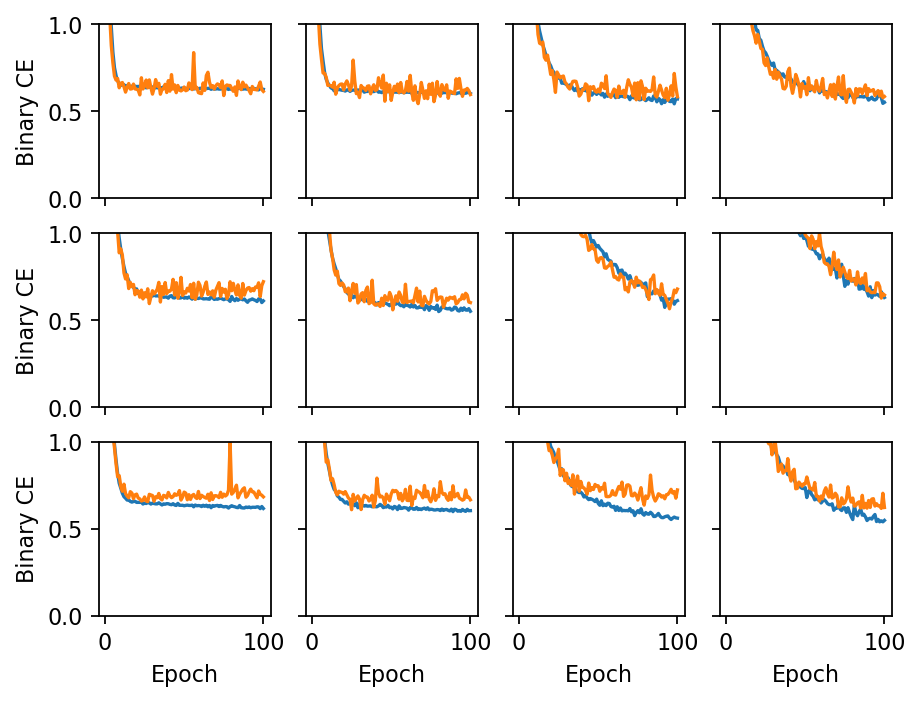

In [8]:
history_r = np.reshape(history, (models_I, models_J))

fig, ax = plt.subplots(len(features), len(targets[0]), sharex=True, sharey=True, dpi = 160)
for i in range(models_I) :
    for j in range(models_J) :
        ax[i, j].plot(np.arange(1, MAX_EPOCHS + 1), history_r[i, j].history['loss'], label = 'Loss')
        ax[i, j].plot(np.arange(1, MAX_EPOCHS + 1), history_r[i, j].history['val_loss'], label = 'Val Loss')
        ax[i, j].set(xlabel = ('Epoch' if i == 2 else ''), ylabel = ('Binary CE' if j == 0 else ''), ylim = [0., 1.])

ROC curves

In [9]:
y_pred = [dnn[0].predict(dnn[3], verbose=0) for dnn in models_dnn]
y_pred = np.reshape(y_pred, (models_I, models_J))

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [10]:
XY_test = [tuple(zip(*dnn[3])) for dnn in models_dnn]
y_true = [np.array(xy_test[1]) for xy_test in XY_test]
y_true = np.reshape(y_true, (models_I, models_J))

Model AUC score: 0.6736903157750868
Model AUC score: 0.715916837827208
Model AUC score: 0.6730485548229038
Model AUC score: 0.6732844866164546
Model AUC score: 0.6087971397340135
Model AUC score: 0.6724113275837414
Model AUC score: 0.5512279740710307
Model AUC score: 0.6582446808510638
Model AUC score: 0.628088861838101
Model AUC score: 0.6654038048107735
Model AUC score: 0.6368522072936661
Model AUC score: 0.6251283463975358


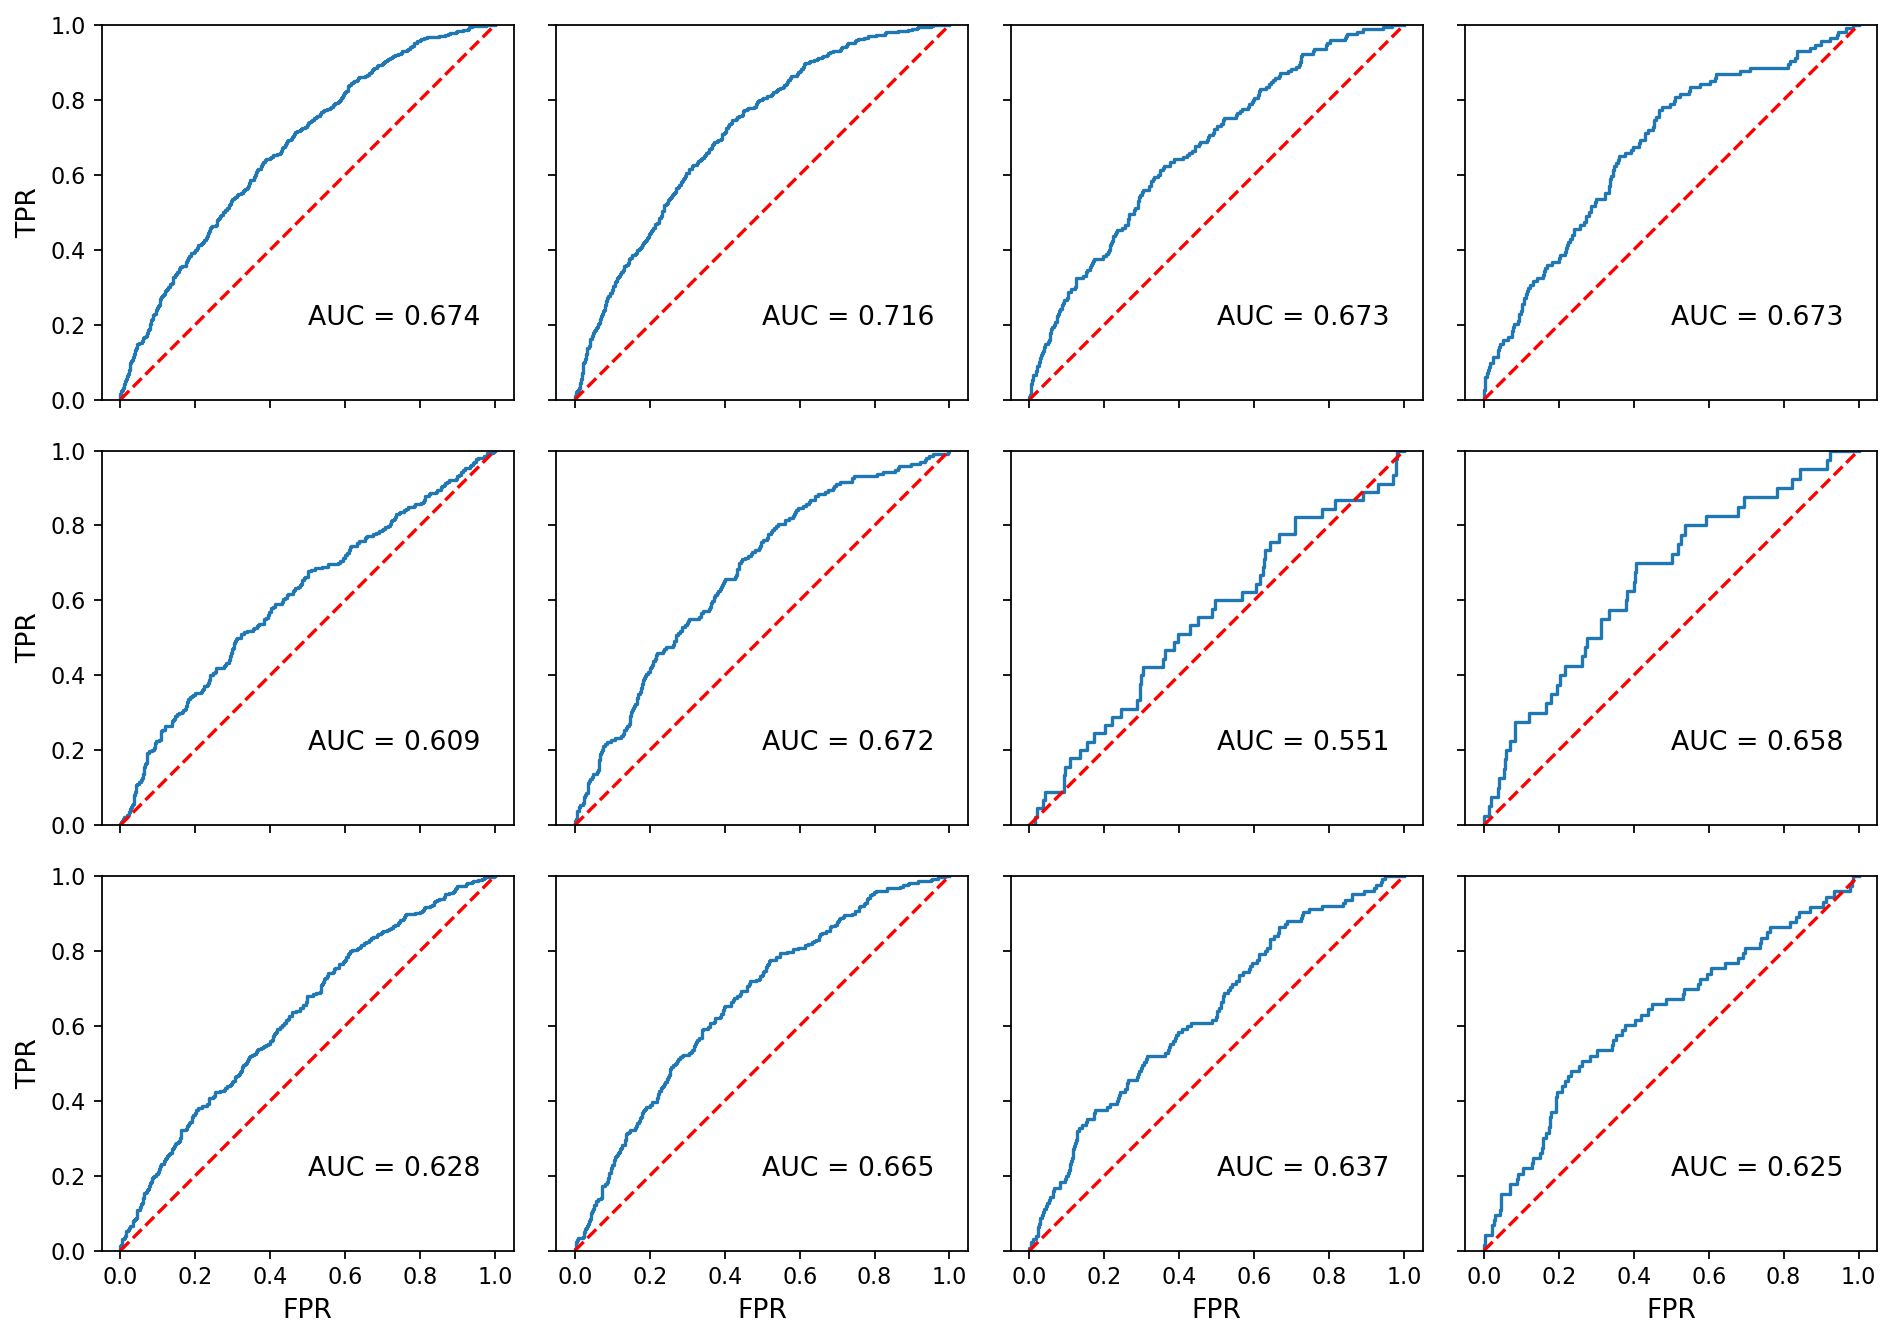

In [107]:
fig, ax = plt.subplots(models_I, models_J, sharex=True, sharey=True, dpi = 160, figsize=(12, 8.5))

for i in range(models_I) :
    for j in range(models_J) :
        fpr, tpr, thresholds = roc_curve(y_true[i, j], y_pred[i, j])  # test dataset
        ax[i, j].plot(fpr, tpr)
        ax[i, j].plot(np.linspace(0,1, 100), np.linspace(0,1,100),'--r')
        ax[i, j].set_xlabel(('FPR' if i == 2 else ''), fontsize = 12)
        ax[i, j].set_ylabel(('TPR' if j == 0 else ''), fontsize = 12)
        ax[i, j].set(ylim = [0., 1.])
        ax[i, j].set_aspect('equal', 'box')
        ax[i, j].text(0.5, 0.2, f'AUC = {roc_auc_score(y_true[i, j], y_pred[i, j]):.3f}', fontsize = 12)
        print(f'Model AUC score: {roc_auc_score(y_true[i, j], y_pred[i, j])}')

fig.tight_layout()

In [112]:
fig.savefig("ROC_MLP.png", dpi = 600) 

#### Evaluate XGBoost models (untuned)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Model AUC score: 0.6392557443520224
Model AUC score: 0.6844983175282962
Model AUC score: 0.652529385701999
Model AUC score: 0.6120250908291047
Model AUC score: 0.6140770797240205
Model AUC score: 0.6935757719339809
Model AUC score: 0.6433662280701754
Model AUC score: 0.5675470925470926
Model AUC score: 0.614552016467593
Model AUC score: 0.6831348247534041
Model AUC score: 0.6257675312199807
Model AUC score: 0.6300617879657596


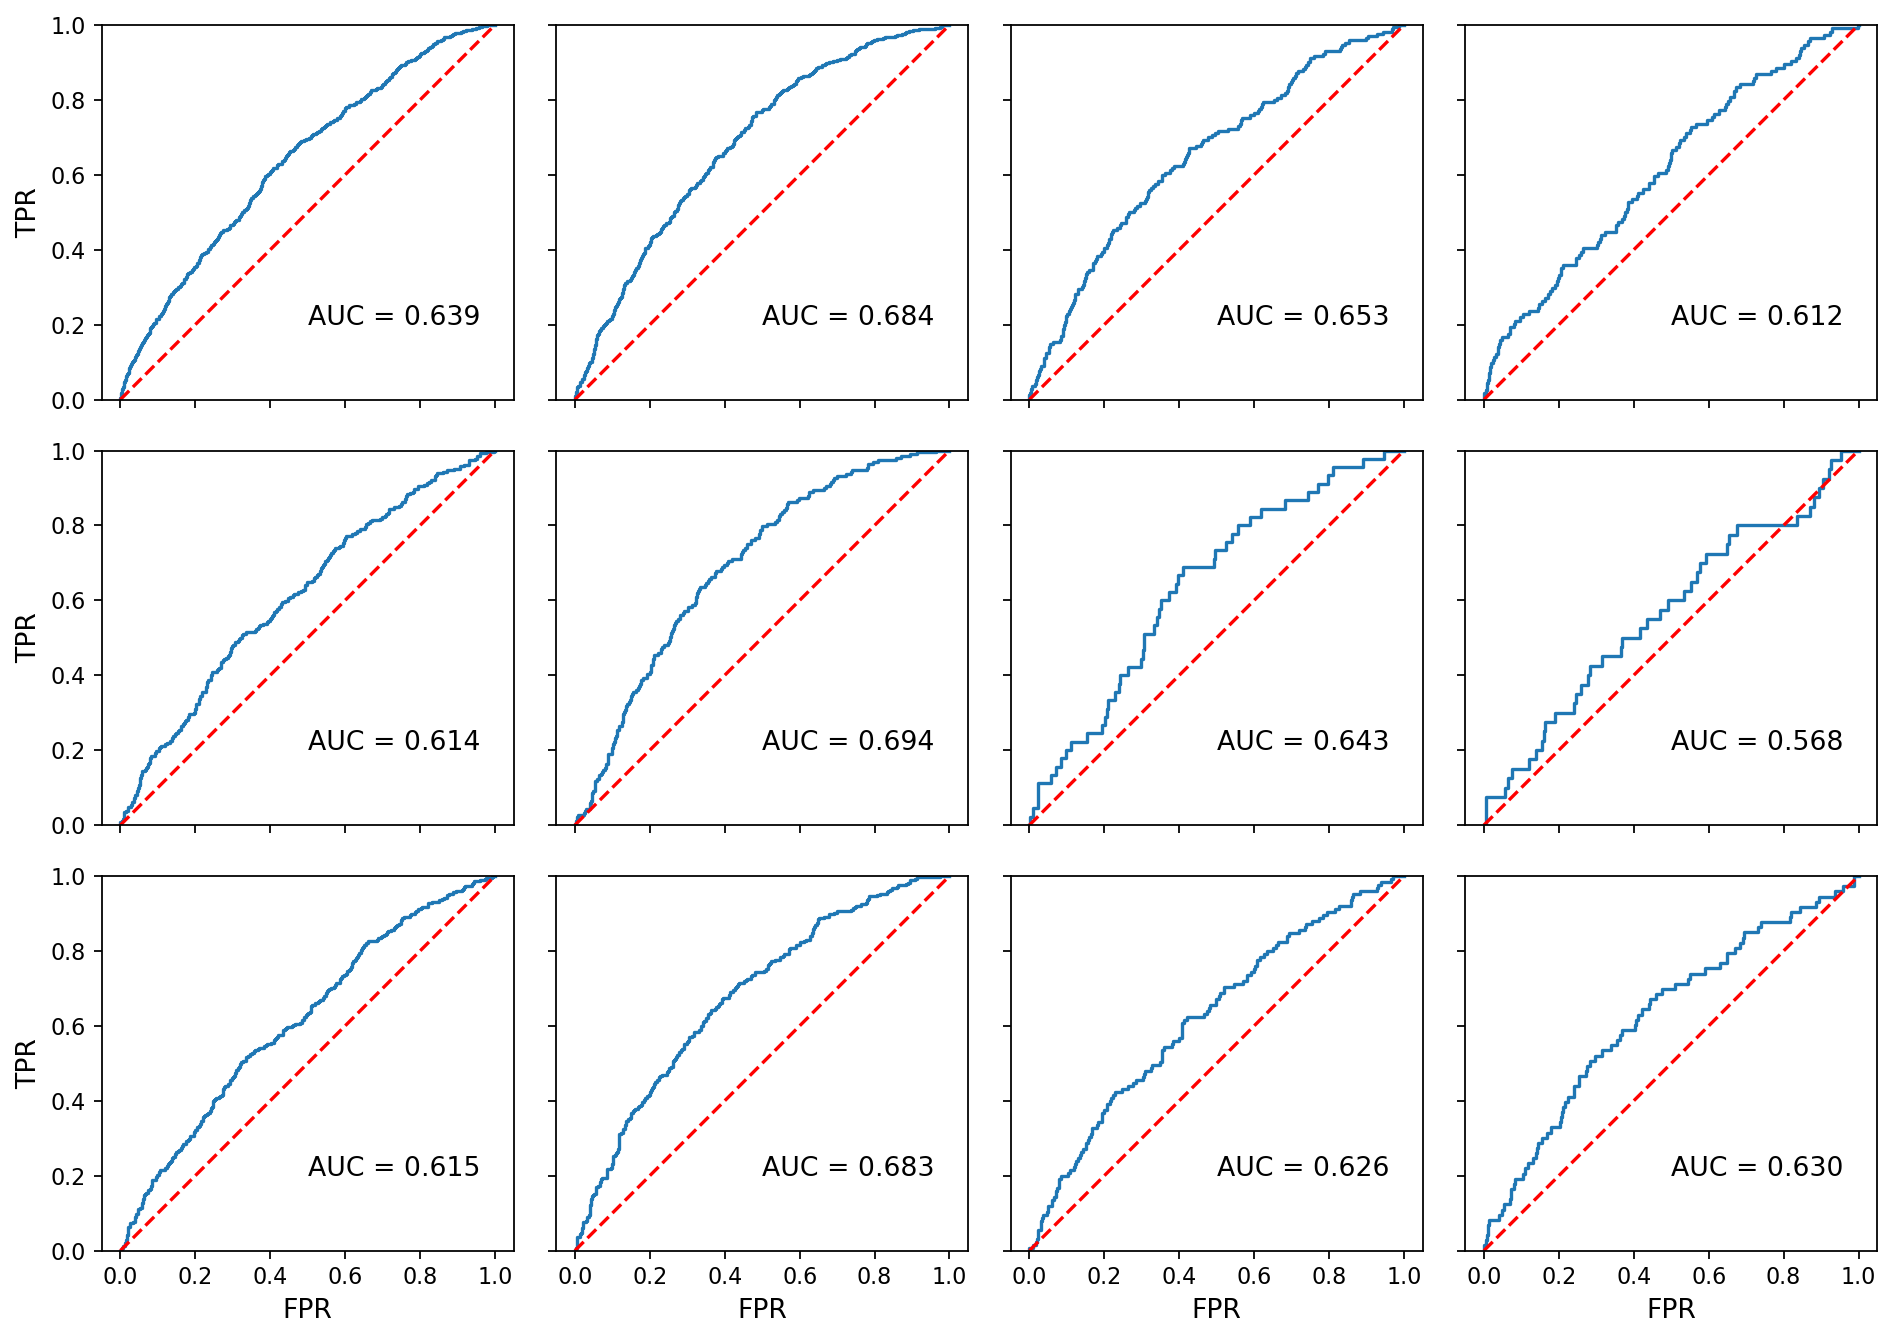

In [113]:
fig, ax = plt.subplots(models_I, models_J, sharex=True, sharey=True, dpi = 160, figsize=(12, 8.5))
XY_xgb_r = np.reshape(XY_xgb, (models_I, models_J, 4))
xgb_classifiers_r = np.reshape(xgb_classifiers, (models_I, models_J))
# xgb_classifiers_tuned = np.reshape(xgb_classifiers_tuned, (models_I, models_J))
for i in range(models_I) :
    for j in range(models_J) :
        xgb_cl = xgb_classifiers_r[i, j]
        x_test_xgb = XY_xgb_r[i, j][1]
        y_true_xgb = XY_xgb_r[i, j][3]
        y_pred_xgb = xgb_cl.predict_proba(x_test_xgb)
        fpr, tpr, thresholds = roc_curve(y_true_xgb, y_pred_xgb[:,1])  # test dataset
        ax[i, j].plot(fpr, tpr)
        
        # xgb_cl_tuned = xgb_classifiers_tuned[i, j]
        # y_pred_xgb_tuned = xgb_cl_tuned.predict_proba(x_test_xgb)
        # fpr, tpr, thresholds = roc_curve(y_true_xgb, y_pred_xgb_tuned[:,1])  # test dataset
        # ax[i, j].plot(fpr, tpr)
        ax[i, j].plot(np.linspace(0,1, 100), np.linspace(0,1,100),'--r')
        ax[i, j].set_xlabel(('FPR' if i == 2 else ''), fontsize = 12)
        ax[i, j].set_ylabel(('TPR' if j == 0 else ''), fontsize = 12)
        ax[i, j].set(ylim = [0., 1.])
        ax[i, j].set_aspect('equal', 'box')
        ax[i, j].text(0.5, 0.2, f'AUC = {roc_auc_score(y_true_xgb, y_pred_xgb[:,1]):.3f}', fontsize = 12)
        print(f'Model AUC score: {roc_auc_score(y_true_xgb, y_pred_xgb[:,1])}')
        
fig.tight_layout()

In [115]:
fig.savefig("ROC_XGB_Untuned.pdf", dpi = 600)

#### Evaluate XGBoost models (tuned)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Model AUC score: 0.6574486017827511
Model AUC score: 0.7180548879080539
Model AUC score: 0.6934400166801323
Model AUC score: 0.6510190304988585
Model AUC score: 0.6470054101699036
Model AUC score: 0.7104902076917001
Model AUC score: 0.6503654970760234
Model AUC score: 0.6157452907452907
Model AUC score: 0.6157268221337451
Model AUC score: 0.6815429659740186
Model AUC score: 0.6708933717579251
Model AUC score: 0.6390981212949153


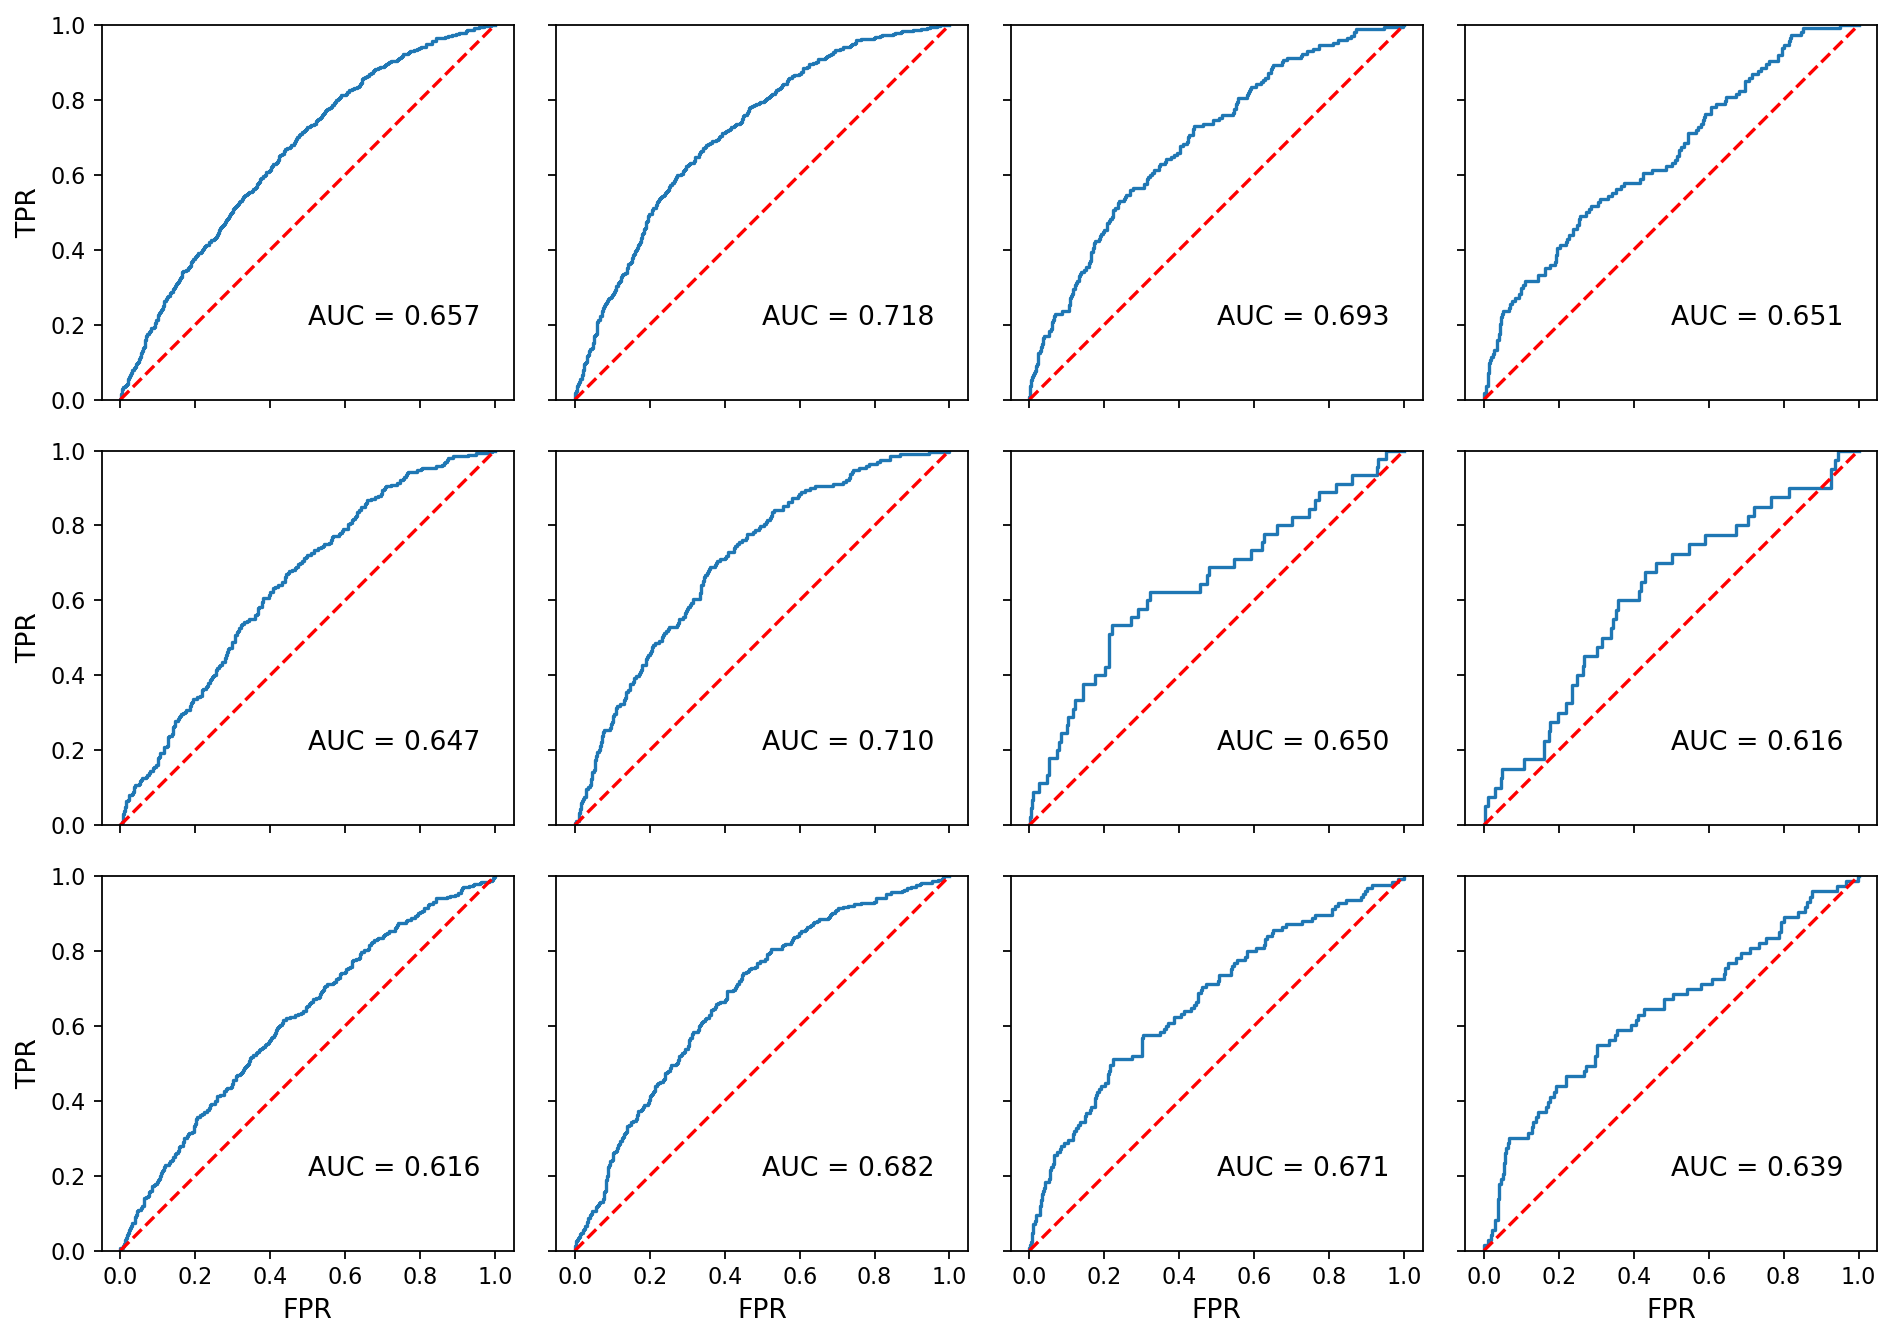

In [119]:
fig, ax = plt.subplots(models_I, models_J, sharex=True, sharey=True, dpi = 160, figsize=(12, 8.5))
XY_xgb_r = np.reshape(XY_xgb, (models_I, models_J, 4))
xgb_classifiers_tuned_r = np.reshape(xgb_classifiers_tuned, (models_I, models_J))
for i in range(models_I) :
    for j in range(models_J) :
        x_test_xgb = XY_xgb_r[i, j][1]
        y_true_xgb = XY_xgb_r[i, j][3]
        
        xgb_cl_tuned = xgb_classifiers_tuned_r[i, j]
        y_pred_xgb_tuned = xgb_cl_tuned.predict_proba(x_test_xgb)
        fpr, tpr, thresholds = roc_curve(y_true_xgb, y_pred_xgb_tuned[:,1])  # test dataset
        ax[i, j].plot(fpr, tpr)
        
        ax[i, j].plot(np.linspace(0, 1, 100), np.linspace(0,1,100),'--r')
        ax[i, j].set_xlabel(('FPR' if i == 2 else ''), fontsize = 12)
        ax[i, j].set_ylabel(('TPR' if j == 0 else ''), fontsize = 12)
        ax[i, j].set(ylim = [0., 1.])
        ax[i, j].set_aspect('equal', 'box')
        ax[i, j].text(0.5, 0.2, f'AUC = {roc_auc_score(y_true_xgb, y_pred_xgb_tuned[:,1]):.3f}', fontsize = 12)
        print(f'Model AUC score: {roc_auc_score(y_true_xgb, y_pred_xgb_tuned[:,1])}')
        
fig.tight_layout()

In [121]:
fig.savefig("ROC_XGB_Tuned.pdf", dpi = 600)

#### Compare DNN to XGBoost

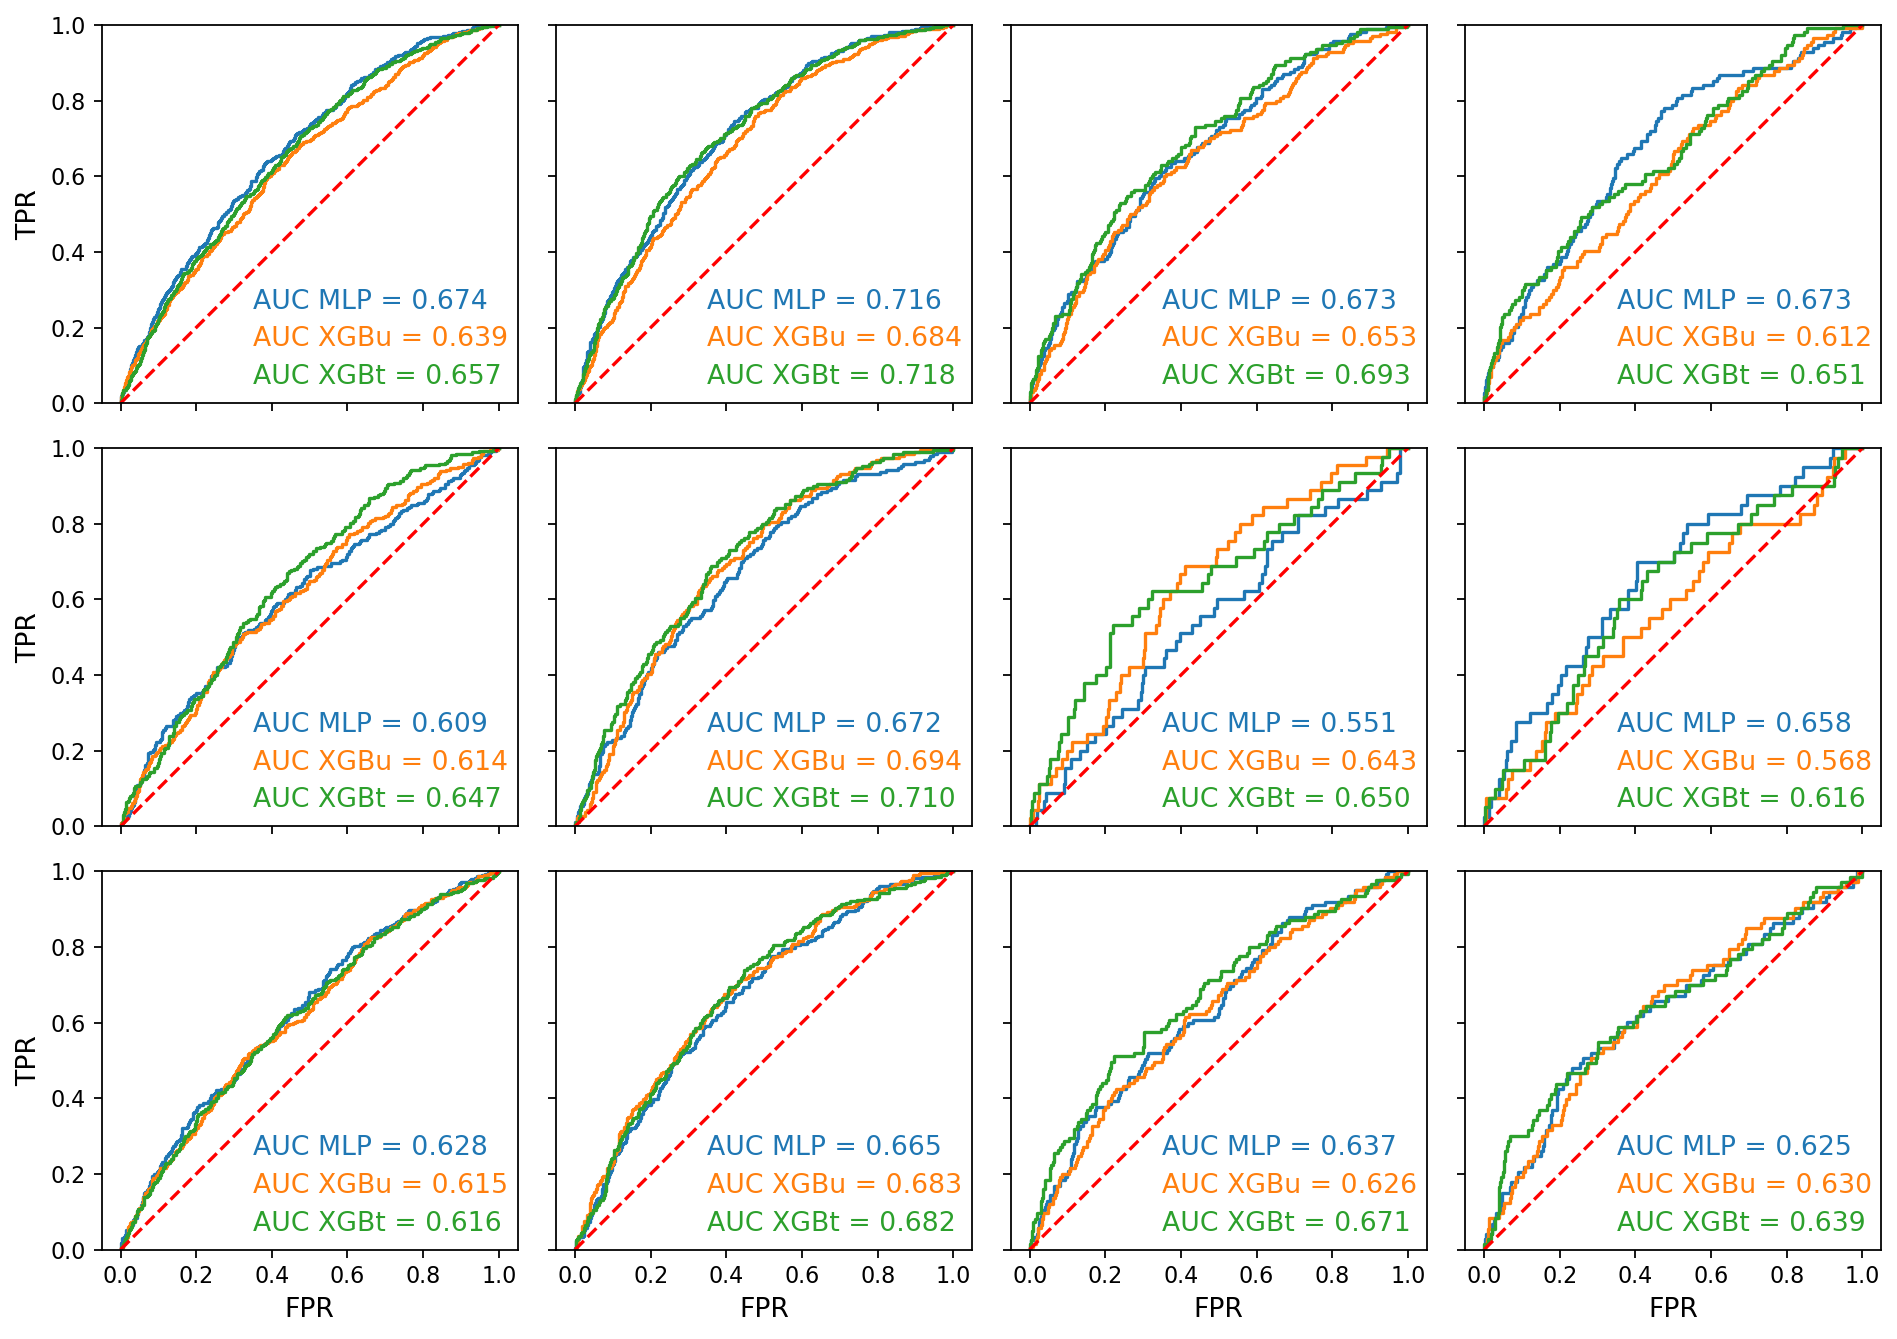

In [127]:
fig, ax = plt.subplots(models_I, models_J, sharex=True, sharey=True, dpi = 160, figsize=(12, 8.5))
fig.tight_layout()
for i in range(models_I) :
    for j in range(models_J) :
        # Baseline DNNs
        fpr, tpr, thresholds = roc_curve(y_true[i, j], y_pred[i, j])  # test dataset
        ax[i, j].plot(fpr, tpr)
        
        # XGBoost (Untuned)
        xgb_cl = xgb_classifiers_r[i, j]
        x_test_xgb = XY_xgb_r[i, j][1]
        y_true_xgb = XY_xgb_r[i, j][3]
        y_pred_xgb = xgb_cl.predict_proba(x_test_xgb)
        fpr, tpr, thresholds = roc_curve(y_true_xgb, y_pred_xgb[:,1])  # test dataset
        ax[i, j].plot(fpr, tpr)
        
        # XGBoost (Tuned)
        xgb_cl_tuned = xgb_classifiers_tuned_r[i, j]
        y_pred_xgb_tuned = xgb_cl_tuned.predict_proba(x_test_xgb)
        fpr, tpr, thresholds = roc_curve(y_true_xgb, y_pred_xgb_tuned[:,1])  # test dataset
        ax[i, j].plot(fpr, tpr)
        
        ax[i, j].plot(np.linspace(0, 1, 100), np.linspace(0,1,100),'--r')
        ax[i, j].set_xlabel(('FPR' if i == 2 else ''), fontsize = 12)
        ax[i, j].set_ylabel(('TPR' if j == 0 else ''), fontsize = 12)
        ax[i, j].set(ylim = [0., 1.])
        ax[i, j].set_aspect('equal', 'box')
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][0:3]
        ax[i, j].text(0.35, 0.25, f'AUC MLP = {roc_auc_score(y_true[i, j], y_pred[i, j]):.3f}', fontsize = 12, color = c[0])
        ax[i, j].text(0.35, 0.15, f'AUC XGBu = {roc_auc_score(y_true_xgb, y_pred_xgb[:,1]):.3f}', fontsize = 12, color = c[1])
        ax[i, j].text(0.35, 0.05, f'AUC XGBt = {roc_auc_score(y_true_xgb, y_pred_xgb_tuned[:,1]):.3f}', fontsize = 12, color = c[2])
        ax[i, j].set(xlabel = ('FPR' if i == 2 else ''), ylabel = ('TPR' if j == 0 else ''), ylim = [0., 1.])

fig.tight_layout()

In [129]:
fig.savefig("ROC_Comparison.pdf", dpi = 600)

In [126]:
plt.rcParams['axes.prop_cycle'].by_key()['color'][0:3]

['#1f77b4', '#ff7f0e', '#2ca02c']

In [194]:
import dill
dill.dump_session('latest_notebook_session.db')

InvalidArgumentError: Cannot convert a Tensor of dtype variant to a NumPy array.

In [6]:
import dill
dill.load_session('latest_notebook_session.db')

EOFError: Ran out of input

## SHAP

#### MLP SHAP

In [12]:
m = len(targets[0][0])
x_train_MLP_SHAP = features_df[0]
x_test_MLP_SHAP = features_df[0].iloc[-int(TEST_SIZE_MLP * m):]
#x_train_MLP_SHAP[::240]

In [13]:
import time
explainer = shap.KernelExplainer(models_dnn[0][0].predict, x_train_MLP_SHAP[::240])  # take ~100 priors (24,000/240), not recommended to have large amount here

4/4 [==============================] - 0s 1ms/step


Using 102 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [14]:
shap_values = explainer.shap_values(x_test_MLP_SHAP, nsamples = 200)

  0%|          | 0/2426 [00:00<?, ?it/s]

638/638 [==============================] - 0s 527us/step


638/638 [==============================] - 0s 537us/step


638/638 [==============================] - 0s 536us/step


638/638 [==============================] - 0s 530us/step


638/638 [==============================] - 0s 545us/step


638/638 [==============================] - 0s 529us/step


638/638 [==============================] - 0s 526us/step


638/638 [==============================] - 0s 536us/step


638/638 [==============================] - 0s 540us/step


638/638 [==============================] - 0s 532us/step


638/638 [==============================] - 0s 529us/step


638/638 [==============================] - 0s 532us/step


638/638 [==============================] - 0s 543us/step


638/638 [==============================] - 0s 526us/step


638/638 [==============================] - 0s 532us/step


638/638 [==============================] - 0s 531us/step


638/638 [==============================] - 0s 532us/step


638/638 [==============================] - 0s 523us/step


638/638 [==============================] - 0s 542us/step


638/638 [==============================] - 0s 532us/step


638/638 [==============================] - 0s 527us/step


638/638 [==============================] - 0s 534us/step


638/638 [==============================] - 0s 532us/step


638/638 [==============================] - 0s 540us/step


638/638 [==============================] - 0s 540us/step


638/638 [==============================] - 0s 537us/step


638/638 [==============================] - 0s 545us/step


638/638 [==============================] - 0s 543us/step


638/638 [==============================] - 0s 536us/step


638/638 [==============================] - 0s 529us/step


638/638 [==============================] - 0s 535us/step


638/638 [==============================] - 0s 534us/step


638/638 [==============================] - 0s 543us/step


In [60]:
%matplotlib inline
shap.summary_plot(shap_values[0], x_test_MLP_SHAP, max_display = 5, show = False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [106]:
plt.clf()

<Figure size 640x480 with 0 Axes>

In [62]:
plt.savefig('SHAP_MLP_5_untuned.png', dpi = 600)

In [105]:
%matplotlib inline

<Figure size 800x950 with 0 Axes>

#### XGBoost SHAP (untuned)

In [80]:
# test data shapley values
explainer_xgbu = shap.TreeExplainer(xgb_classifiers[0])
shap_values_xgbu = explainer_xgbu.shap_values(XY_xgb[0][1])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [102]:
plt.clf()
%matplotlib auto
shap.summary_plot(shap_values_xgbu, XY_xgb[0][1], max_display = 20, show = False)

Using matplotlib backend: QtAgg


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [103]:
plt.savefig('SHAP_XGB_20_untuned.pdf', dpi = 600)

#### XGBoost SHAP (tuned)

In [130]:
# test data shapley values
explainer_xgbu_tuned = shap.TreeExplainer(xgb_classifiers_tuned[0])
shap_values_xgbu_tuned = explainer_xgbu_tuned.shap_values(XY_xgb[0][1])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [137]:
plt.clf()
%matplotlib auto
shap.summary_plot(shap_values_xgbu_tuned, XY_xgb[0][1], max_display = 5, show = False)

Using matplotlib backend: QtAgg


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [139]:
plt.savefig('SHAP_XGB_5_tuned.png', dpi = 600)

## MLP Hyperparameter (Work in progress)

In [ ]:
class MyHyperModel(kt.HyperModel) :
    def __init__(self, normalizer):
        self.normalizer = normalizer
    
    def build(self, hp) : 
        model = tf.keras.Sequential()
        model.add(self.normalizer)
        # model.add(tf.keras.layers.Input(53))
        
        # Tune the number of units in the first Dense layer
        # Choose an optimal value between 32-512
        hp_units = hp.Int('units', min_value=10, max_value=160, step=10)
        hp_layers = hp.Int('layers', min_value = 1, max_value = 6, step = 1)
        hp_l2reg = hp.Choice('lambda', values = [1e-4, 1e-3, 1e-2, 1e-1])
        for l in range(hp_layers):
            model.add(tf.keras.layers.Dense(units = hp_units, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(hp_l2reg)))
            model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

        return model
    
    
    def fit(self, hp, model, x, *args, **kwargs) :
        
        return model.fit(x, *args, **kwargs)

In [ ]:
tuner = kt.BayesianOptimization(hypermodel=MyHyperModel(normalizer),
                     objective = "val_accuracy", #optimize val acc
                     overwrite=True,  #overwrite previous results
                     directory='hyperband_search_dir', #Saving dir
                     project_name='CardiacClassifiers')

In [ ]:
tuner.search(x = train_ds, steps_per_epoch = STEPS_PER_EPOCH, epochs=50, validation_data = validate_ds)

In [ ]:
best_hps = tuner.get_best_hyperparameters(1)
h_model = MyHyperModel(normalizer)
model = h_model.build(best_hps[0])

In [ ]:
MAX_EPOCHS = 200
history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = MAX_EPOCHS,
    validation_data = validate_ds,
    verbose = 1)

In [ ]:
plt.plot(np.arange(1, MAX_EPOCHS + 1), history.history['loss'], label = 'Loss')
plt.plot(np.arange(1, MAX_EPOCHS + 1), history.history['val_loss'], label = 'Val Loss')
plt.ylabel('Binary cross-entropy', size = 14)
plt.xlabel('Epoch', size = 14)
plt.ylim([0., 1.])
plt.legend();